In [1]:
import numpy as np
import torch
from torchvision import datasets, transforms
import time
import cv2


In [2]:

!git clone https://github.com/shhommychon/mnist_generative_practice.git

import sys
sys.path = ["./mnist_generative_practice"] + sys.path

Cloning into 'mnist_generative_practice'...
remote: Enumerating objects: 35, done.
remote: Counting objects: 100% (35/35), done.
remote: Compressing objects: 100% (25/25), done.
remote: Total 35 (delta 12), reused 30 (delta 7), pack-reused 0 (from 0)
Receiving objects: 100% (35/35), 1.60 MiB | 4.30 MiB/s, done.
Resolving deltas: 100% (12/12), done.


In [3]:
!apt install megatools

# mnist_feature_extractor.dth
!megadl 'https://mega.nz/file/DgUQyDyB#7Gyq_9kzCz8FcGZV659VD1Cq1_36wimGVOG2Eram3P8'

# mnist_classifier.dth
!megadl 'https://mega.nz/file/H49S3bTI#qsonzlkV3JMniTbyzV77BB9VLhwmh1OJLTgxuD4PEMM'

Reading package lists... Done
Building dependency tree... Done
Reading state information... Done
The following NEW packages will be installed:
  megatools
0 upgraded, 1 newly installed, 0 to remove and 49 not upgraded.
Need to get 207 kB of archives.
After this operation, 898 kB of additional disk space will be used.
Get:1 http://archive.ubuntu.com/ubuntu jammy/universe amd64 megatools amd64 1.10.3-1build1 [207 kB]
Fetched 207 kB in 1s (233 kB/s)
Selecting previously unselected package megatools.
(Reading database ... 123630 files and directories currently installed.)
Preparing to unpack .../megatools_1.10.3-1build1_amd64.deb ...
Unpacking megatools (1.10.3-1build1) ...
Setting up megatools (1.10.3-1build1) ...
Processing triggers for man-db (2.10.2-1) ...
Downloaded mnist_feature_extractor.dth
Downloaded mnist_classifier.dth


In [4]:

!apt install megatools

# mnist_diffusion.dth
!megadl 'https://mega.nz/file/Sg90lRhQ#LBZAwdB26Il-cqFYs7Q-WpX7AOWwRl2a1OlQ2vXK9J4'

Reading package lists... Done
Building dependency tree... Done
Reading state information... Done
megatools is already the newest version (1.10.3-1build1).
0 upgraded, 0 newly installed, 0 to remove and 49 not upgraded.
Downloaded mnist_diffusion.dth


In [5]:
def zernfun(n, m, r, theta, nflag=None):
    """
    Zernike functions of order N and frequency M on the unit circle.
    """
    import numpy as np
    from math import factorial

    # Input validation
    if not (np.ndim(n) == 1 and np.ndim(m) == 1):
        raise ValueError('N and M must be vectors.')

    if len(n) != len(m):
        raise ValueError('N and M must be the same length.')

    n = np.array(n).flatten()
    m = np.array(m).flatten()

    if np.any((n - m) % 2 != 0):
        raise ValueError('All N and M must differ by multiples of 2 (including 0).')

    if np.any(m > n):
        raise ValueError('Each M must be less than or equal to its corresponding N.')

    if np.any((r > 1) | (r < 0)):
        raise ValueError('All R must be between 0 and 1.')

    if not (np.ndim(r) == 1 and np.ndim(theta) == 1):
        raise ValueError('R and THETA must be vectors.')

    r = np.array(r).flatten()
    theta = np.array(theta).flatten()
    length_r = len(r)
    if length_r != len(theta):
        raise ValueError('The number of R- and THETA-values must be equal.')

    # Check normalization
    if nflag is not None and isinstance(nflag, str):
        isnorm = nflag.lower() == 'norm'
        if not isnorm and nflag != '':
            raise ValueError('Unrecognized normalization flag.')
    else:
        isnorm = False

    # Compute the Zernike polynomials
    m_abs = np.abs(m)
    rpowers = []
    for j in range(len(n)):
        rpowers.extend(range(int(m_abs[j]), int(n[j]) + 1, 2))
    rpowers = np.unique(rpowers)

    # Pre-compute the values of r raised to the required powers
    rpowern = np.zeros((length_r, len(rpowers)))
    for idx, p in enumerate(rpowers):
        rpowern[:, idx] = r ** p

    # Compute the values of the polynomials
    z = np.zeros((length_r, len(n)))
    for j in range(len(n)):
        n_j = int(n[j])
        m_abs_j = int(m_abs[j])
        s_max = (n_j - m_abs_j) // 2
        s = np.arange(0, s_max + 1)
        pows = np.arange(n_j, m_abs_j - 1, -2)
        for k in range(len(s)):
            s_k = int(s[k])
            pow_k = int(pows[k])
            numerator = (-1) ** s_k * factorial(n_j - s_k)
            denominator = (factorial(s_k) *
                           factorial((n_j + m_abs_j) // 2 - s_k) *
                           factorial((n_j - m_abs_j) // 2 - s_k))
            p = numerator / denominator
            idx_rpow = np.where(rpowers == pow_k)[0][0]
            z[:, j] += p * rpowern[:, idx_rpow]

        if isnorm:
            z[:, j] *= np.sqrt((1 + (m[j] != 0)) * (n[j] + 1) / np.pi)

    # Compute the Zernike functions
    idx_pos = m > 0
    idx_neg = m < 0

    if np.any(idx_pos):
        z[:, idx_pos] *= np.cos(theta[:, np.newaxis] * m_abs[idx_pos])
    if np.any(idx_neg):
        z[:, idx_neg] *= np.sin(theta[:, np.newaxis] * m_abs[idx_neg])

    return z


In [6]:
def gen_aberration(NA_mask, N_NA, max_value, Max_N):
    """
    Generate aberration phase map and coefficients
    """
    import numpy as np
    k_index = np.nonzero(NA_mask)
    N_img = NA_mask.shape[0]

    kx, ky = np.meshgrid(np.arange(1, N_img + 1), np.arange(1, N_img + 1))
    kc = np.mean(kx)
    kx = kx.astype(float) - kc
    ky = ky.astype(float) - kc
    kx = kx / float(N_NA)
    ky = ky / float(N_NA)
    kx = kx[k_index]
    ky = ky[k_index]

    N_z = []
    M_z = []
    for n in range(0, Max_N + 1):
        N_z.extend([n] * (n + 1))
        M_z.extend(range(-n, n + 1, 2))

    N_z = np.array(N_z)
    M_z = np.array(M_z)
    theta, rho = np.arctan2(ky, kx), np.hypot(kx, ky)
    z = zernfun(N_z, M_z, rho, theta)
    j_max = z.shape[1]

    z_norm = np.sum(z * z, axis=0)
    for j in range(j_max):
        if M_z[j] == 0:
            epsilon = 2
        else:
            epsilon = 1
        z_norm[j] = z_norm[j] * (2 * N_z[j] + 2) / (epsilon * np.pi)
    z_norm = np.sqrt(z_norm)

    linear_coeff = -max_value * (N_z - Max_N - 1).astype(float) / float(Max_N)
    z_coefficients = linear_coeff * (np.random.rand(j_max) - 0.5)

    z_coefficients[0] = 0  # DC offset

    tmp_map = np.sum(z * (z_coefficients / z_norm), axis=1)
    phase_map = np.zeros((N_img, N_img))
    phase_map[k_index] = tmp_map
    phase_map = (phase_map + np.pi) % (2 * np.pi) - np.pi

    return phase_map, z_coefficients


In [7]:
# [00] Data options
full_opt = 1  # 1600(1), 1264(0)
basis = 'kx'  # kk, kx, rr

target_opt = 'lm'

abin_cpx = 'non'  # rand, non, exrand, (fix)
about_cpx = 'non'
about_fact = 10
abin_fact = 10

comp_opt = 'reim'  # angle, reim

sc_opt = 1  # scattering off(0)/on(1)
MS = 10
SM = 1 / MS  # single/multi intensity ratio

# [0] Parameters setup

NAsz = 20  # radius of pupil [pixel] corresponding to koNA, 21 for 0.4NA 40um FoV (L/dx)
matsz = 4 * NAsz  # [pixel] corresponding to 4*koNA w/ Kpadding

lamb = 0.8  # wavelength [um]
dx = lamb / 0.4 / 2  # NA resolution, 2pi/(2koNA) [um] *2 for 0.2NA
xtick = dx * np.arange(1, matsz + 1) / 2  # tick in x-space, /2 for 2koNA(radius) matrix (Kpadded)
xtick = xtick - np.mean(xtick)

dk = 2 * 2 * np.pi / dx  # maximum k radius, 2*koNA [/um]  2* for K padding (=4*koNA diameter)
ktick = dk / matsz * np.arange(1, matsz + 1)  # tick in k-space
ktick = ktick - np.mean(ktick)

xx, yy = np.meshgrid(np.arange(1, matsz + 1), np.arange(1, matsz + 1))
rr = (xx - np.mean(xx)) + 1j * (yy - np.mean(yy))

cmask = np.sqrt((xx - np.mean(xx)) ** 2 + (yy - np.mean(yy)) ** 2) / NAsz
cmask[cmask <= 1] = 1
cmask[cmask > 1] = 0

if full_opt == 1:
    nzind = np.arange(0, (2 * NAsz) ** 2)
else:
    cmask_crop = cmask[NAsz:3 * NAsz, NAsz:3 * NAsz]
    nzind = np.nonzero(cmask_crop)


In [8]:
# Load MNIST dataset
mnist_testset = datasets.MNIST(root='./data', train=False, download=True,
                      transform=transforms.Compose([transforms.ToTensor()]))

# Get an image
img, label = mnist_testset[5002]  # Indexing from 0, so 5002 corresponds to 5003rd image
tmp = img.squeeze().numpy()  # Get a numpy array of shape (28,28)

# Pad or resize the image
if target_opt == 'sm':
    pad_amount = int(2 * NAsz - tmp.shape[0] / 2)  # Should be 26
    tobj = np.pad(tmp, pad_amount, mode='constant', constant_values=0)
elif target_opt == 'lm':
    # Resize the image to 80x80
    tobj = cv2.resize(tmp, (80, 80))


Failed to download (trying next):
HTTP Error 403: Forbidden



100%|██████████| 9.91M/9.91M [00:00<00:00, 16.4MB/s]


Extracting ./data/MNIST/raw/train-images-idx3-ubyte.gz to ./data/MNIST/raw

Failed to download (trying next):
HTTP Error 403: Forbidden



100%|██████████| 28.9k/28.9k [00:00<00:00, 495kB/s]


Extracting ./data/MNIST/raw/train-labels-idx1-ubyte.gz to ./data/MNIST/raw

Failed to download (trying next):
HTTP Error 403: Forbidden



100%|██████████| 1.65M/1.65M [00:00<00:00, 4.46MB/s]


Extracting ./data/MNIST/raw/t10k-images-idx3-ubyte.gz to ./data/MNIST/raw

Failed to download (trying next):
HTTP Error 403: Forbidden



100%|██████████| 4.54k/4.54k [00:00<00:00, 6.15MB/s]

Extracting ./data/MNIST/raw/t10k-labels-idx1-ubyte.gz to ./data/MNIST/raw



In [9]:
start_time = time.time()

if comp_opt == 'reim':
    data_mat = np.zeros((2 * NAsz, 2 * NAsz, len(nzind) * 2))
    truth_mat = np.zeros((2 * NAsz, 2 * NAsz, 4))

# Prepare xin-kout (if basis is 'kx')
if basis == 'kx':
    xinkout = np.zeros(((2 * NAsz) ** 2, (2 * NAsz) ** 2), dtype=complex)
    for ii in range((2 * NAsz) ** 2):
        xin = np.zeros((2 * NAsz, 2 * NAsz), dtype=complex)
        xin.flat[ii] = 1
        tmp = np.fft.ifftshift(np.fft.fft2(np.fft.fftshift(xin)))
        xinkout[:, ii] = tmp.flatten()

# Continue with the rest of the computation
xx, yy = np.meshgrid(np.arange(1, 4 * NAsz + 1), np.arange(1, 4 * NAsz + 1))
re = 2
cmask2 = np.sqrt((xx - np.mean(xx)) ** 2 + (yy - np.mean(yy)) ** 2) / (re * NAsz)
cmask2[cmask2 <= 1] = 1
cmask2[cmask2 > 1] = 0

target = np.fft.fftshift(np.fft.fft2(tobj))
# target = target * cmask2  # Uncomment if needed

ktarget = target * cmask  # r=40 mask
ktarget = ktarget[NAsz:3 * NAsz, NAsz:3 * NAsz]

xtarget = np.fft.ifft2(np.fft.ifftshift(target))

# Generate kin-kout matrix
kxtmp, kytmp = np.meshgrid(np.arange(-NAsz, NAsz), np.arange(-NAsz, NAsz))
kx = kxtmp.flatten()
ky = kytmp.flatten()
n1 = (2 * NAsz) ** 2

Smat = np.zeros((n1, n1), dtype=complex)

for ii in range(n1):
    tmp = np.roll(np.roll(target, int(kx[ii]), axis=0), int(ky[ii]), axis=1) * cmask
    tmp = tmp[NAsz:3 * NAsz, NAsz:3 * NAsz]
    Smat[:, ii] = tmp.flatten()


In [10]:
# Create input/output pupil function matrix
sz = 2 * NAsz
kx2, ky2 = np.meshgrid(np.arange(1, sz + 1), np.arange(1, sz + 1))
kc = 20.5  # sz / 2 + 1
NA_mask = (kx2 - kc) ** 2 + (ky2 - kc) ** 2 < NAsz ** 2
roi_NA = np.arange(kc - NAsz, kc + NAsz)
k_index = np.nonzero(NA_mask)

ipf = np.zeros((2 * NAsz, 2 * NAsz), dtype=complex)

if abin_cpx == 'rand':
    abin_fact = 10 + 50 * np.random.rand()  # degree of aberration (10~60)

ab_phase_map, z_coeff = gen_aberration(NA_mask, NAsz, 50, int(abin_fact))

if abin_cpx == 'exrand':
    ab_phase_map = 2 * 3.14 * np.random.rand(40, 40) - 3.14
elif abin_cpx == 'ramp':
    ramp = np.zeros((40, 40))
    for i in range(40):
        ramp[i, :] = -np.pi + i * np.pi / 40
    ab_phase_map = ramp

ipf[k_index] = np.exp(1j * ab_phase_map[k_index])

if abin_cpx == 'non':
    ipf[NA_mask] = 1.0  # no aberration

# Similarly for opf
opf = np.zeros((2 * NAsz, 2 * NAsz), dtype=complex)

if about_cpx == 'rand':
    about_fact = 10 + 50 * np.random.rand()  # degree of aberration (10~60)

ab_phase_map_opf, z_coeff_opf = gen_aberration(NA_mask, NAsz, 50, int(about_fact))

if about_cpx == 'exrand':
    ab_phase_map_opf = 2 * 3.14 * np.random.rand(40, 40) - 3.14
elif about_cpx == 'ramp':
    ramp = np.zeros((40, 40))
    for i in range(40):
        ramp[i, :] = -np.pi + i * np.pi / 40
    ab_phase_map_opf = ramp

opf[k_index] = np.exp(1j * ab_phase_map_opf[k_index])

if about_cpx == 'non':
    opf[NA_mask] = 1.0  # no aberration

# Apply pupil functions
ipf_flat = ipf.flatten()
opf_flat = opf.flatten()

Smat = (opf_flat[:, np.newaxis]) * Smat * (ipf_flat[np.newaxis, :])


In [11]:
kxmat = Smat
kxmat = kxmat[:, nzind]

if basis == 'kx':
    kxmat = kxmat @ xinkout

if basis == 'rr':
    kxmat = kxmat @ kxmat.T

rimat = np.zeros((40, 40, len(nzind) * 2))
trmat = np.zeros((40, 40, truth_mat.shape[2]))

if basis == 'rr':
   abin_tmp = np.conj(opf)
else:
   abin_tmp = ipf
about_tmp = opf

if sc_opt == 1:
    chan = kxmat.shape[0]
    Mmat = np.random.randn(chan, chan) + 1j * np.random.randn(chan, chan)

    IM = np.mean(np.sum(np.abs(Mmat) ** 2))
    IS = np.mean(np.sum(np.abs(kxmat) ** 2))

    mat = kxmat * np.sqrt(IM / IS * SM) + Mmat
    kxmat = mat[:, nzind]
else:
    kxmat = kxmat[:, nzind]

rimat[:, :, 0::2] = np.real(kxmat).reshape(40, 40, -1)
rimat[:, :, 1::2] = np.imag(kxmat).reshape(40, 40, -1)

trmat[:, :, 0] = np.real(about_tmp).reshape(40, 40)
trmat[:, :, 1] = np.imag(about_tmp).reshape(40, 40)
trmat[:, :, 2] = np.real(abin_tmp).reshape(40, 40)
trmat[:, :, 3] = np.imag(abin_tmp).reshape(40, 40)

data_mat = rimat
truth_mat = trmat

end_time = time.time()
print("Time taken:", end_time - start_time)


Time taken: 1.3770740032196045


In [12]:
import os

if full_opt == 1:
    matloc = f'test_data/{basis}_full/{target_opt}/{about_cpx}/'
else:
    matloc = f'test_data/{basis}/{target_opt}/{about_cpx}/'

if not os.path.exists(matloc):
    os.makedirs(matloc)

dataloc = os.path.join(matloc, 'data_mat.npy')
truthloc = os.path.join(matloc, 'truth_mat.npy')

np.save(dataloc, data_mat)
np.save(truthloc, truth_mat)

print("Data saved.")


Data saved.


In [14]:
pip install diffusion-models


In [15]:
mnist_trainset = datasets.MNIST(root='./data', train=True, download=True,
                      transform=transforms.Compose([transforms.ToTensor()]))
mnist_testset = datasets.MNIST(root='./data', train=False, download=True,
                      transform=transforms.Compose([transforms.ToTensor()]))

mnist_valset, mnist_testset = torch.utils.data.random_split(
                                mnist_testset,
                                [
                                    int(0.9 * len(mnist_testset)),
                                    int(0.1 * len(mnist_testset))
                                ]
                            )
train_dataloader = torch.utils.data.DataLoader(mnist_trainset, batch_size=64, shuffle=True)
val_dataloader = torch.utils.data.DataLoader(mnist_valset, batch_size=32, shuffle=False)
test_dataloader = torch.utils.data.DataLoader(mnist_testset, batch_size=32, shuffle=False)

print("Training dataset size: ", len(mnist_trainset))
print("Validation dataset size: ", len(mnist_valset))
print("Testing dataset size: ", len(mnist_testset))

Training dataset size:  60000
Validation dataset size:  9000
Testing dataset size:  1000


# Scattering denoise vs Gaussian denoise

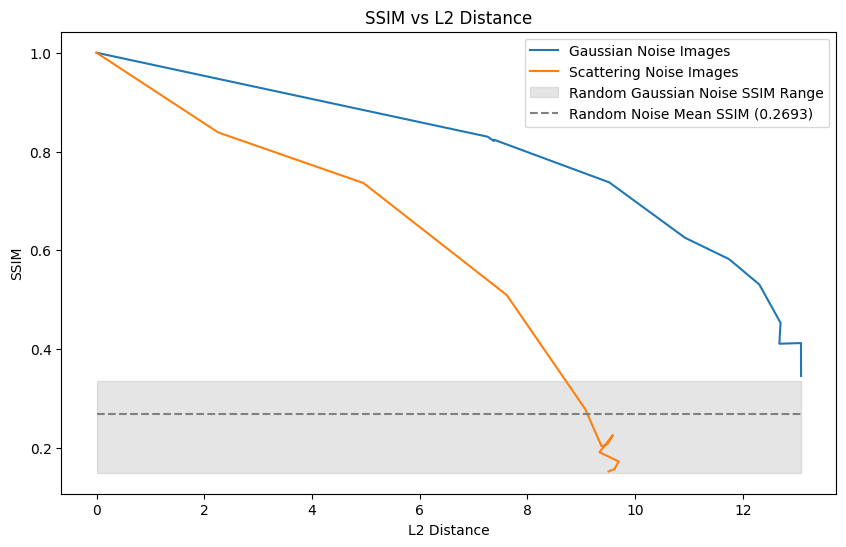

In [193]:
import matplotlib.pyplot as plt

# 데이터 리스트

# 가우시안 노이즈 이미지의 L2 거리와 SSIM 값
gaussian_L2 = [0, 7.2629, 7.3763, 7.3817, 9.5197, 10.9263, 11.7449, 12.3062, 12.6995, 12.6779, 13.0794, 13.0805]
gaussian_SSIM = [1.0, 0.8300, 0.8214, 0.8239, 0.7376, 0.6255, 0.5822, 0.5309, 0.4533, 0.4111, 0.4124, 0.3459]

# 스캐터링 노이즈 이미지의 L2 거리와 SSIM 값
scattering_L2 = [0, 2.2588, 4.9539, 7.6171, 9.0736, 9.3756, 9.4842, 9.5864, 9.3373, 9.6949, 9.6144, 9.5066]
scattering_SSIM = [1.0, 0.8387, 0.7364, 0.5095, 0.2788, 0.2038, 0.2076, 0.2260, 0.1915, 0.1728, 0.1571, 0.1526]

# 랜덤 가우시안 노이즈의 SSIM 값
random_SSIM = [0.2506, 0.2506, 0.3207, 0.2846, 0.2845, 0.2414, 0.3249, 0.3348, 0.2851, 0.2777, 0.2528, 0.2427,0.15]

# 랜덤 가우시안 노이즈의 SSIM 통계 계산
random_ssim_min = min(random_SSIM)
random_ssim_max = max(random_SSIM)
random_ssim_mean = sum(random_SSIM) / len(random_SSIM)

# 그래프 생성
plt.figure(figsize=(10, 6))

# 선 1: 가우시안 노이즈 이미지
plt.plot(gaussian_L2, gaussian_SSIM, label='Gaussian Noise Images')

# 선 2: 스캐터링 노이즈 이미지
plt.plot(scattering_L2, scattering_SSIM, label='Scattering Noise Images')

# 랜덤 가우시안 노이즈: SSIM의 최대값과 최소값 사이를 면적으로 채우고, 평균 SSIM 값에 선을 그림
max_L2 = max(max(gaussian_L2), max(scattering_L2))
plt.fill_between([0, max_L2],
                 random_ssim_min, random_ssim_max,
                 color='gray', alpha=0.2, label='Random Gaussian Noise SSIM Range')

plt.hlines(random_ssim_mean, xmin=0, xmax=max_L2,
           colors='gray', linestyles='dashed', label=f'Random Noise Mean SSIM ({random_ssim_mean:.4f})')

# 그래프 설정
plt.xlabel('L2 Distance')
plt.ylabel('SSIM')
plt.title('SSIM vs L2 Distance')
plt.legend()
plt.show()


<ipython-input-185-94ce2af96163>:173: FutureWarning: You are using `torch.load` with `weights_only=False` (the current default value), which uses the default pickle module implicitly. It is possible to construct malicious pickle data which will execute arbitrary code during unpickling (See https://github.com/pytorch/pytorch/blob/main/SECURITY.md#untrusted-models for more details). In a future release, the default value for `weights_only` will be flipped to `True`. This limits the functions that could be executed during unpickling. Arbitrary objects will no longer be allowed to be loaded via this mode unless they are explicitly allowlisted by the user via `torch.serialization.add_safe_globals`. We recommend you start setting `weights_only=True` for any use case where you don't have full control of the loaded file. Please open an issue on GitHub for any issues related to this experimental feature.
  model.load_state_dict(torch.load("mnist_diffusion.dth", map_location=device))


MS = 0.1, t = 1
스캐터링 노이즈 이미지 - PSNR: 22.02 dB, L2 거리: 2.2588
가우시안 노이즈 이미지 - PSNR: 11.73 dB, L2 거리: 7.2629
랜덤 가우시안 노이즈 - PSNR: -0.37 dB, L2 거리: 29.2284
스캐터링 노이즈 복원 이미지 SSIM: 0.8387
가우시안 노이즈 복원 이미지 SSIM: 0.8300
랜덤 노이즈 복원 이미지 SSIM: 0.2506



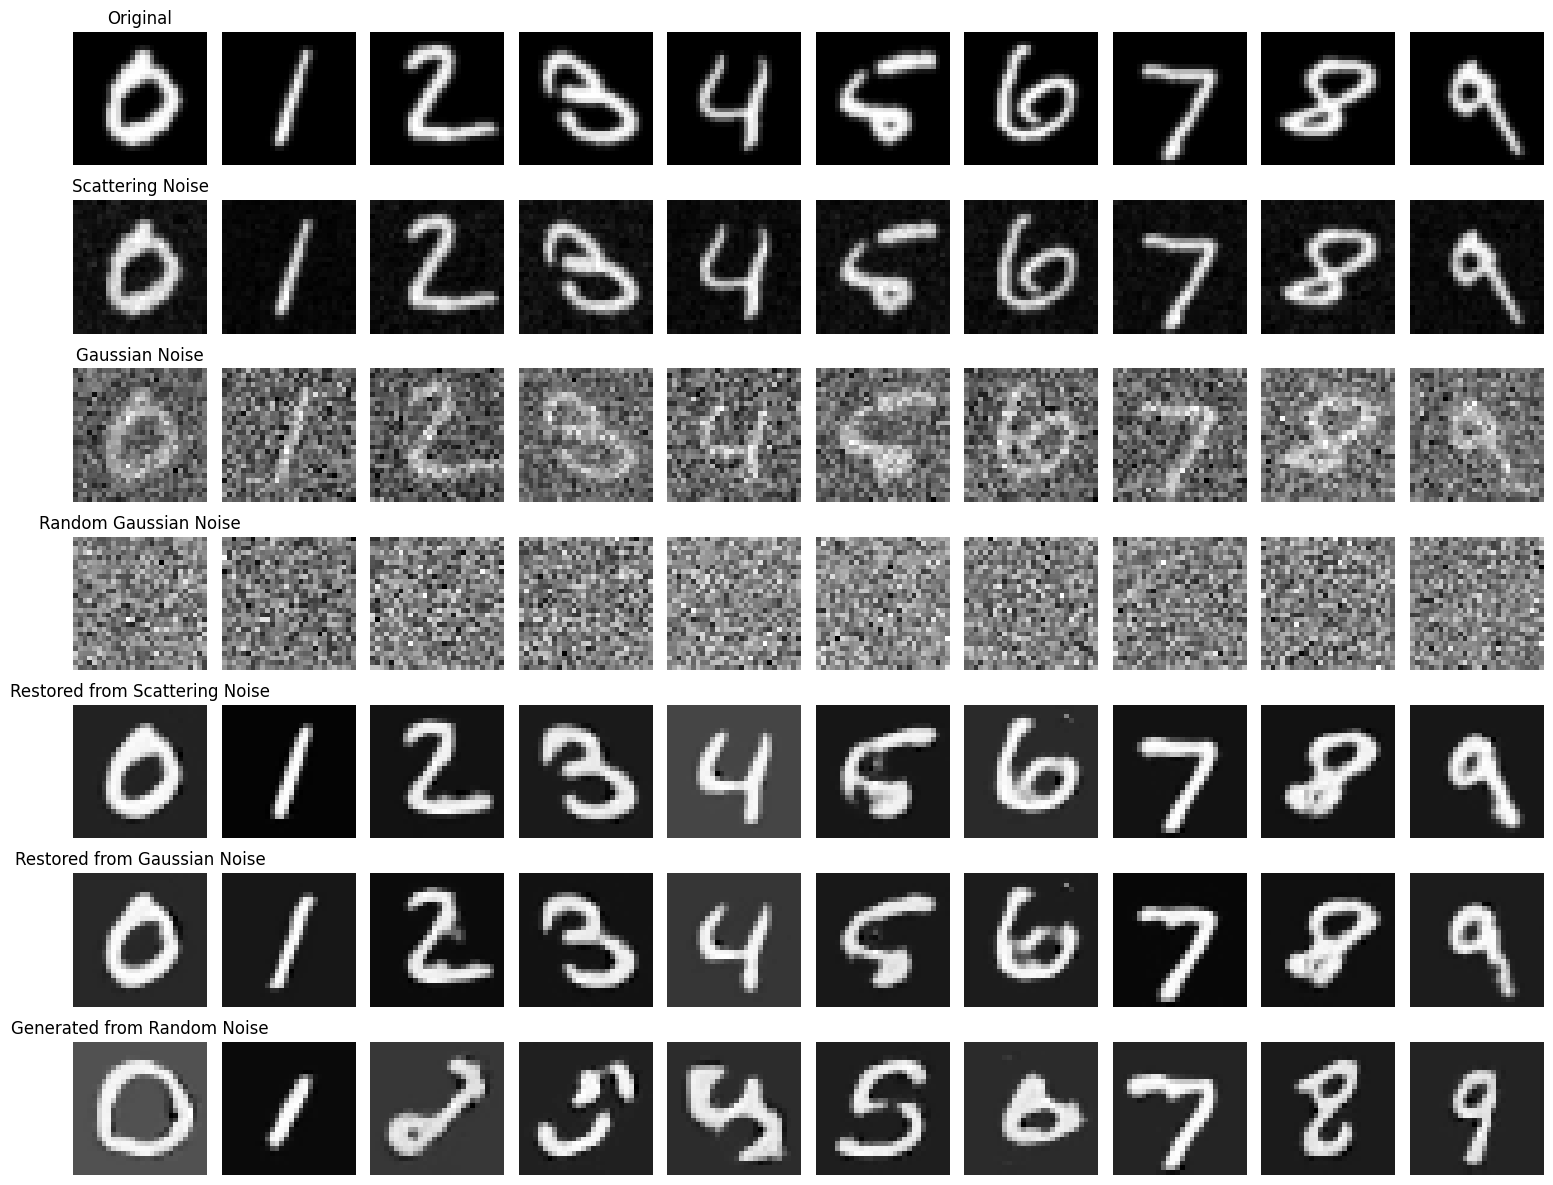

MS = 1, t = 1
스캐터링 노이즈 이미지 - PSNR: 15.17 dB, L2 거리: 4.9539
가우시안 노이즈 이미지 - PSNR: 11.59 dB, L2 거리: 7.3763
랜덤 가우시안 노이즈 - PSNR: -0.43 dB, L2 거리: 29.4364
스캐터링 노이즈 복원 이미지 SSIM: 0.7364
가우시안 노이즈 복원 이미지 SSIM: 0.8214
랜덤 노이즈 복원 이미지 SSIM: 0.3207



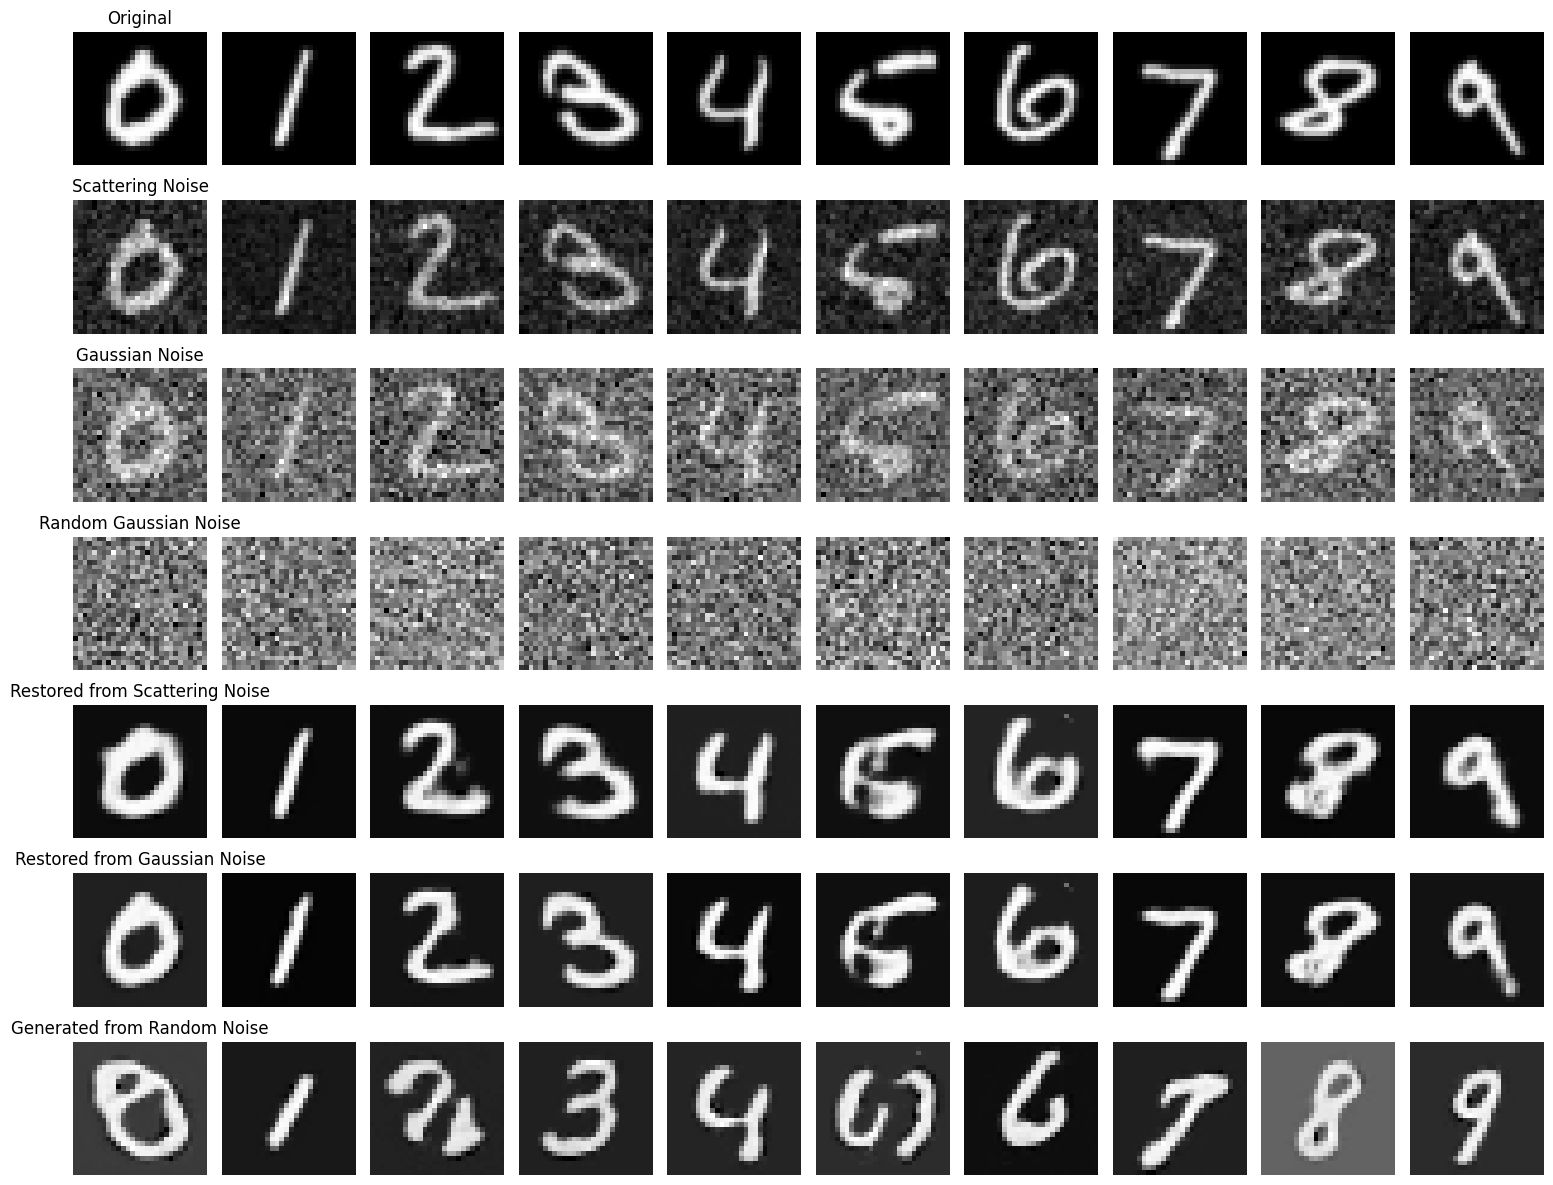

MS = 5, t = 1
스캐터링 노이즈 이미지 - PSNR: 11.38 dB, L2 거리: 7.6171
가우시안 노이즈 이미지 - PSNR: 11.58 dB, L2 거리: 7.3817
랜덤 가우시안 노이즈 - PSNR: -0.52 dB, L2 거리: 29.7513
스캐터링 노이즈 복원 이미지 SSIM: 0.5095
가우시안 노이즈 복원 이미지 SSIM: 0.8239
랜덤 노이즈 복원 이미지 SSIM: 0.2846



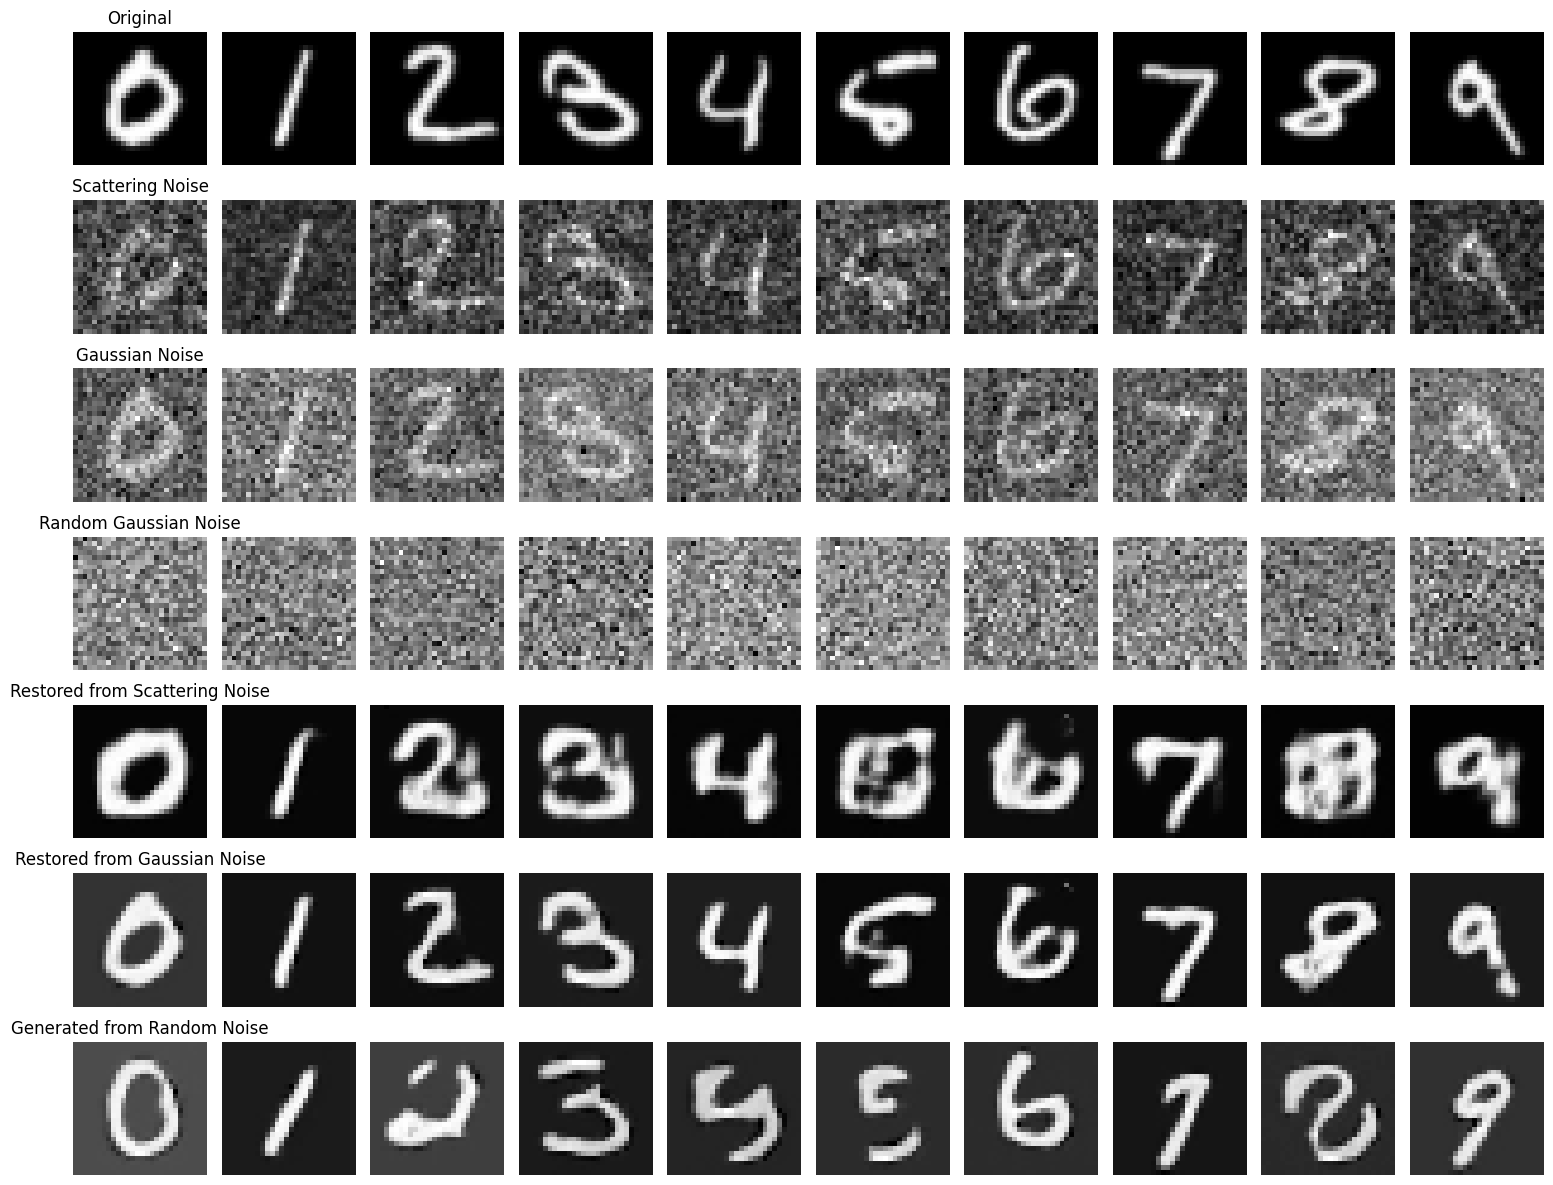

MS = 20, t = 2
스캐터링 노이즈 이미지 - PSNR: 9.82 dB, L2 거리: 9.0736
가우시안 노이즈 이미지 - PSNR: 9.38 dB, L2 거리: 9.5197
랜덤 가우시안 노이즈 - PSNR: -0.44 dB, L2 거리: 29.4737
스캐터링 노이즈 복원 이미지 SSIM: 0.2788
가우시안 노이즈 복원 이미지 SSIM: 0.7376
랜덤 노이즈 복원 이미지 SSIM: 0.2845



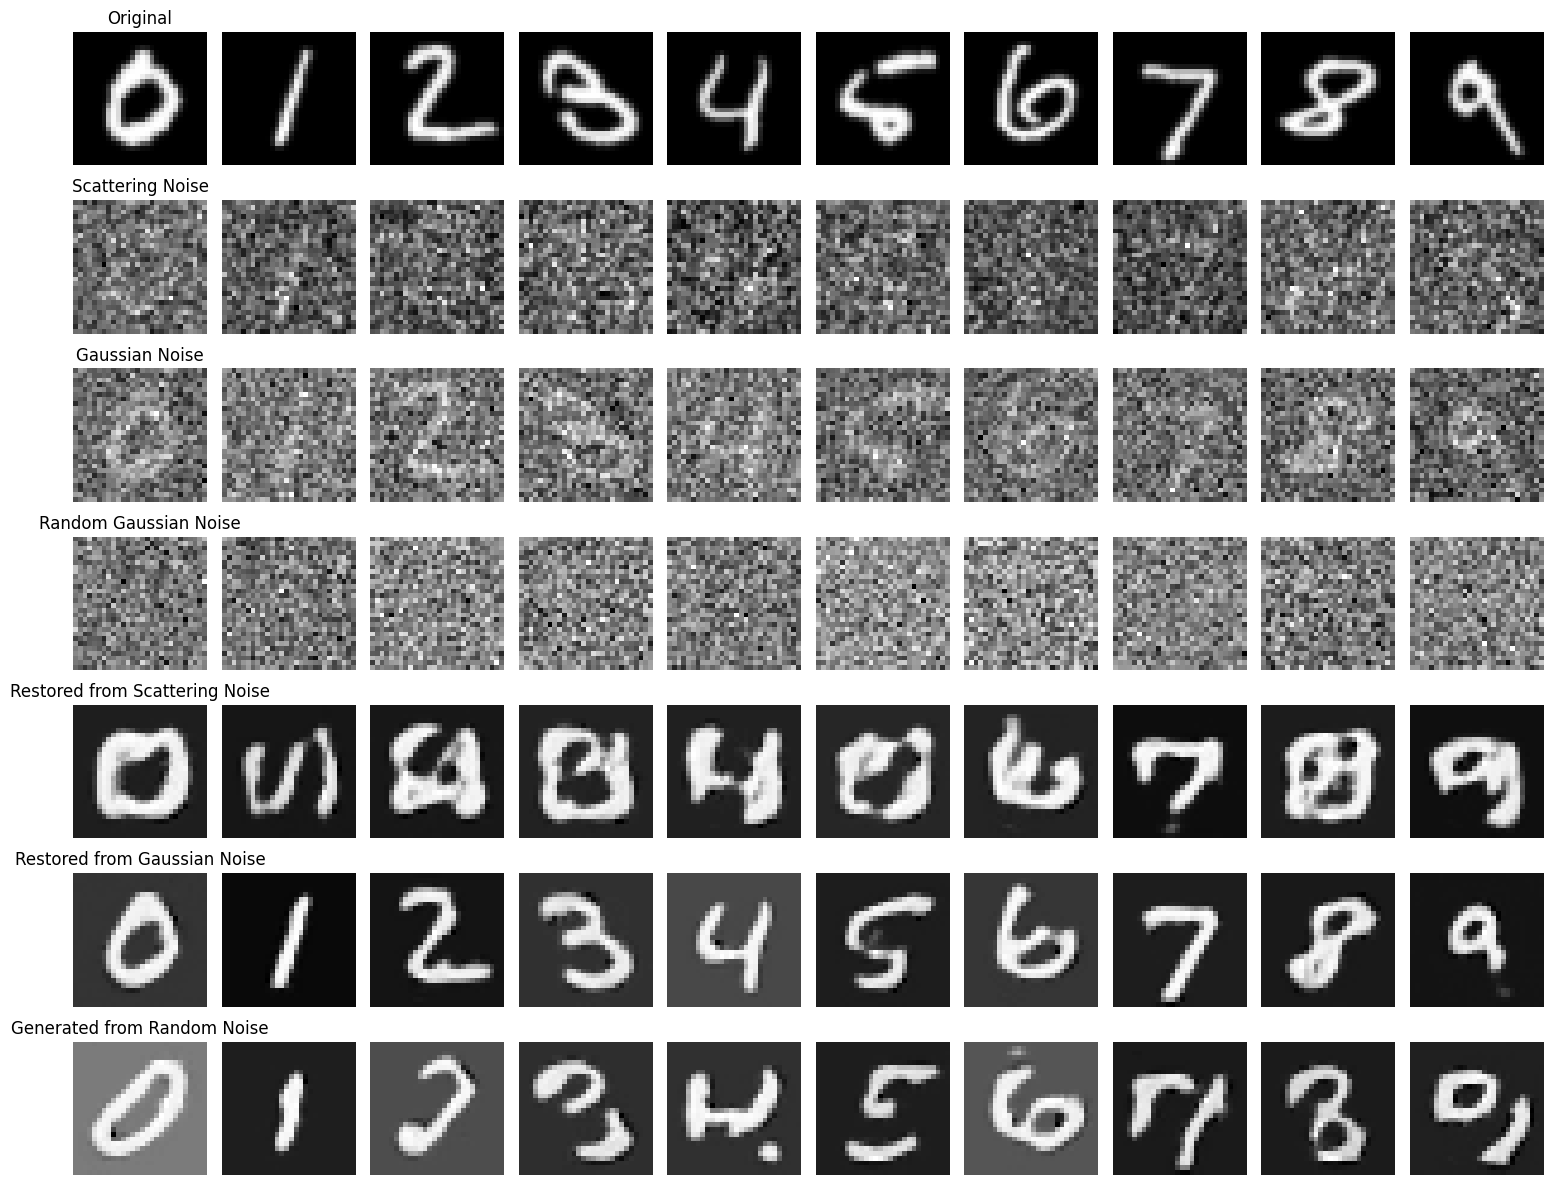

MS = 30, t = 3
스캐터링 노이즈 이미지 - PSNR: 9.52 dB, L2 거리: 9.3756
가우시안 노이즈 이미지 - PSNR: 8.19 dB, L2 거리: 10.9263
랜덤 가우시안 노이즈 - PSNR: -0.29 dB, L2 거리: 28.9473
스캐터링 노이즈 복원 이미지 SSIM: 0.2038
가우시안 노이즈 복원 이미지 SSIM: 0.6255
랜덤 노이즈 복원 이미지 SSIM: 0.2414



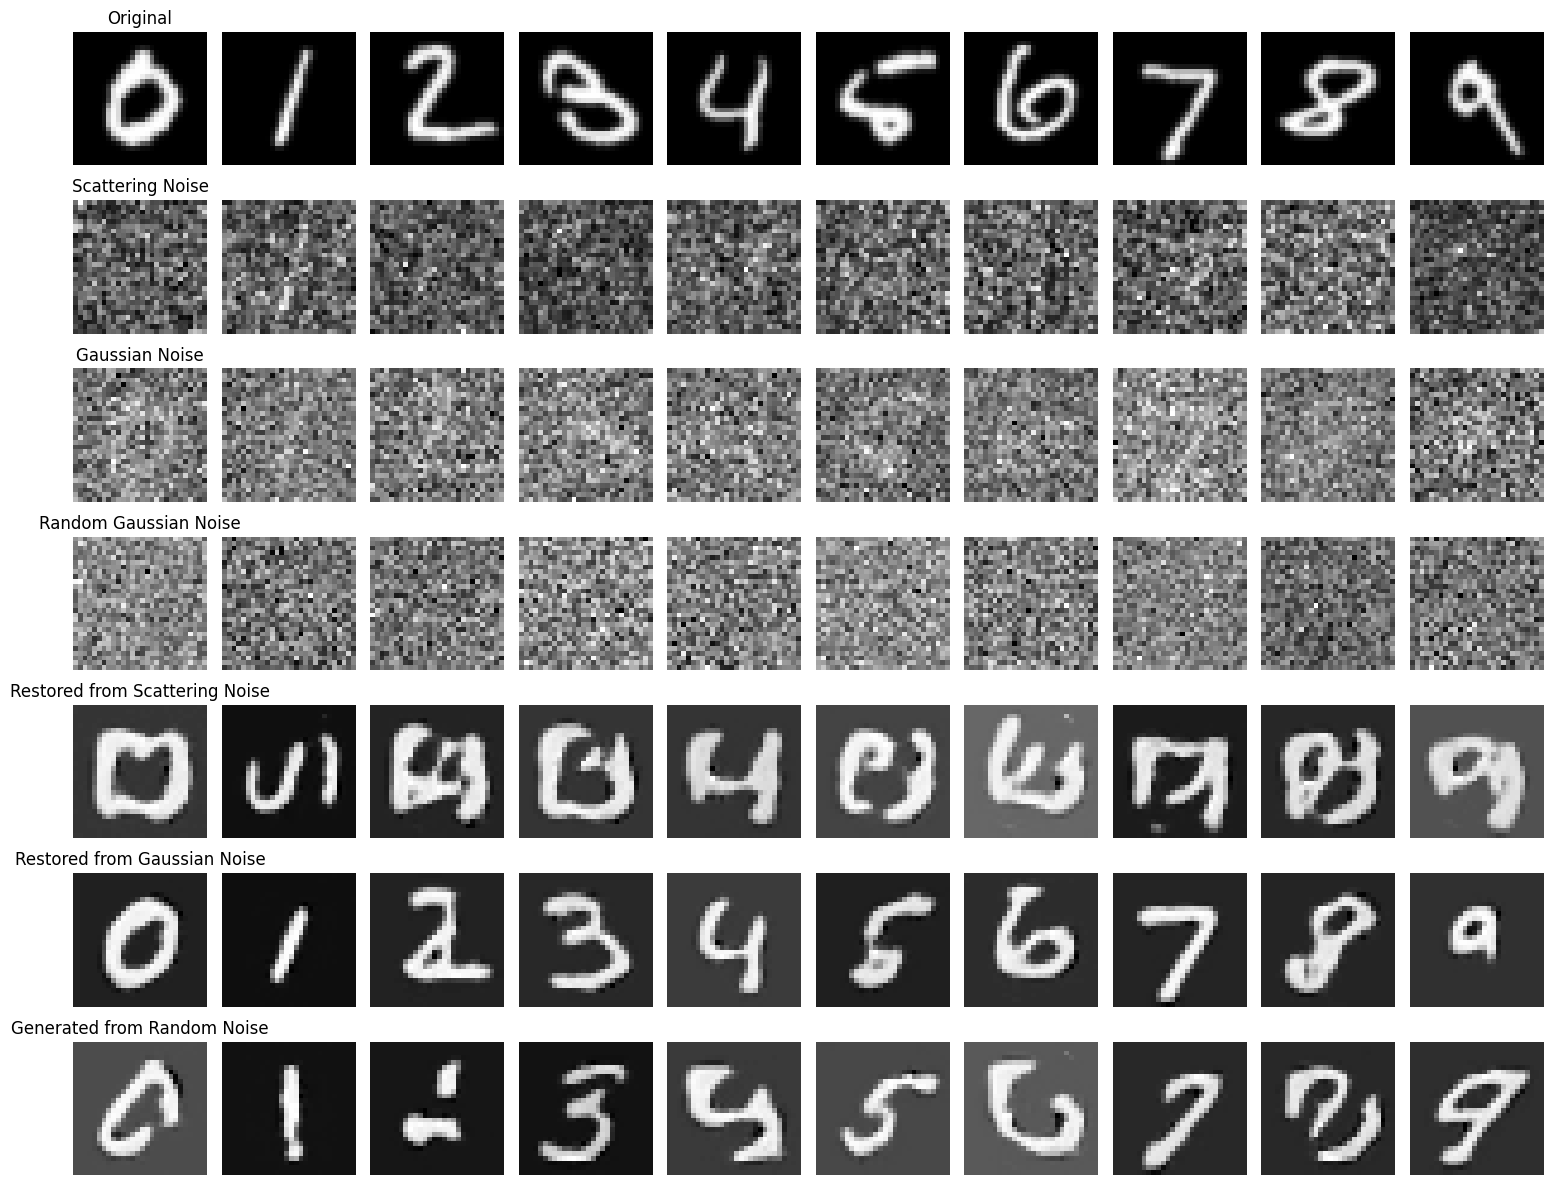

MS = 40, t = 4
스캐터링 노이즈 이미지 - PSNR: 9.43 dB, L2 거리: 9.4842
가우시안 노이즈 이미지 - PSNR: 7.56 dB, L2 거리: 11.7449
랜덤 가우시안 노이즈 - PSNR: -0.29 dB, L2 거리: 28.9462
스캐터링 노이즈 복원 이미지 SSIM: 0.2076
가우시안 노이즈 복원 이미지 SSIM: 0.5822
랜덤 노이즈 복원 이미지 SSIM: 0.3249



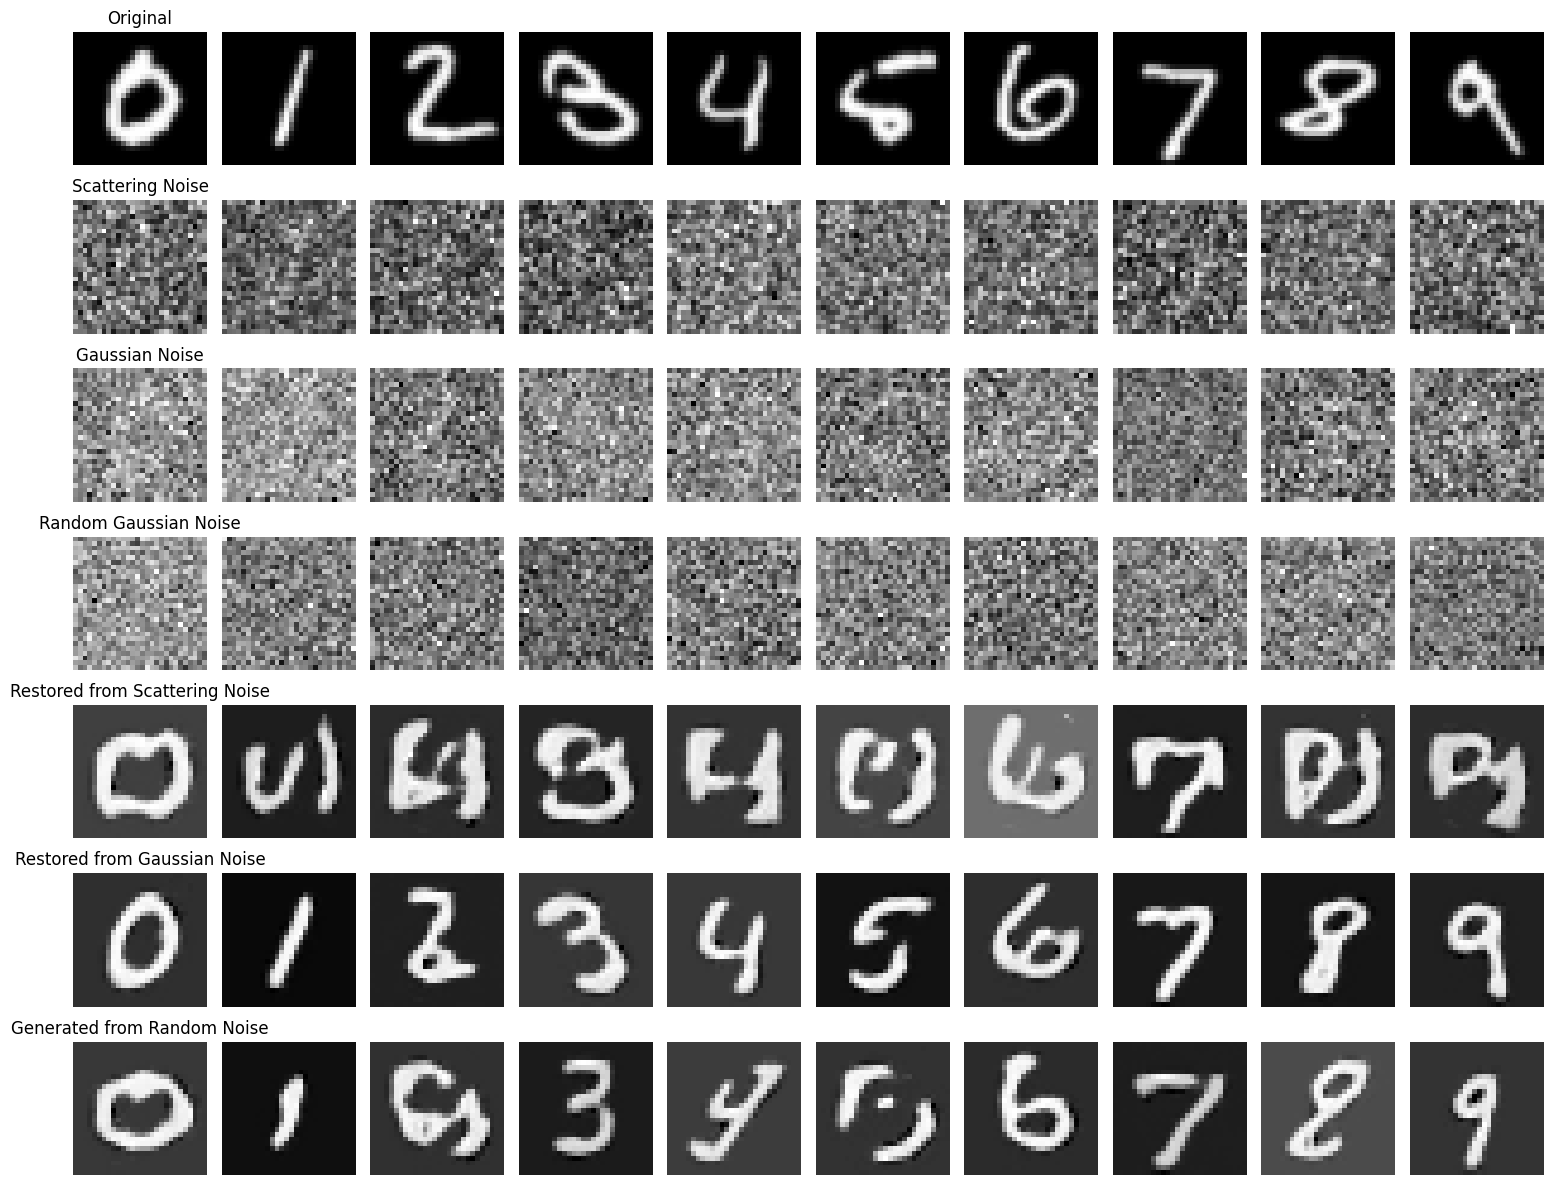

MS = 50, t = 5
스캐터링 노이즈 이미지 - PSNR: 9.34 dB, L2 거리: 9.5864
가우시안 노이즈 이미지 - PSNR: 7.16 dB, L2 거리: 12.3062
랜덤 가우시안 노이즈 - PSNR: -0.30 dB, L2 거리: 28.9941
스캐터링 노이즈 복원 이미지 SSIM: 0.2260
가우시안 노이즈 복원 이미지 SSIM: 0.5309
랜덤 노이즈 복원 이미지 SSIM: 0.3348



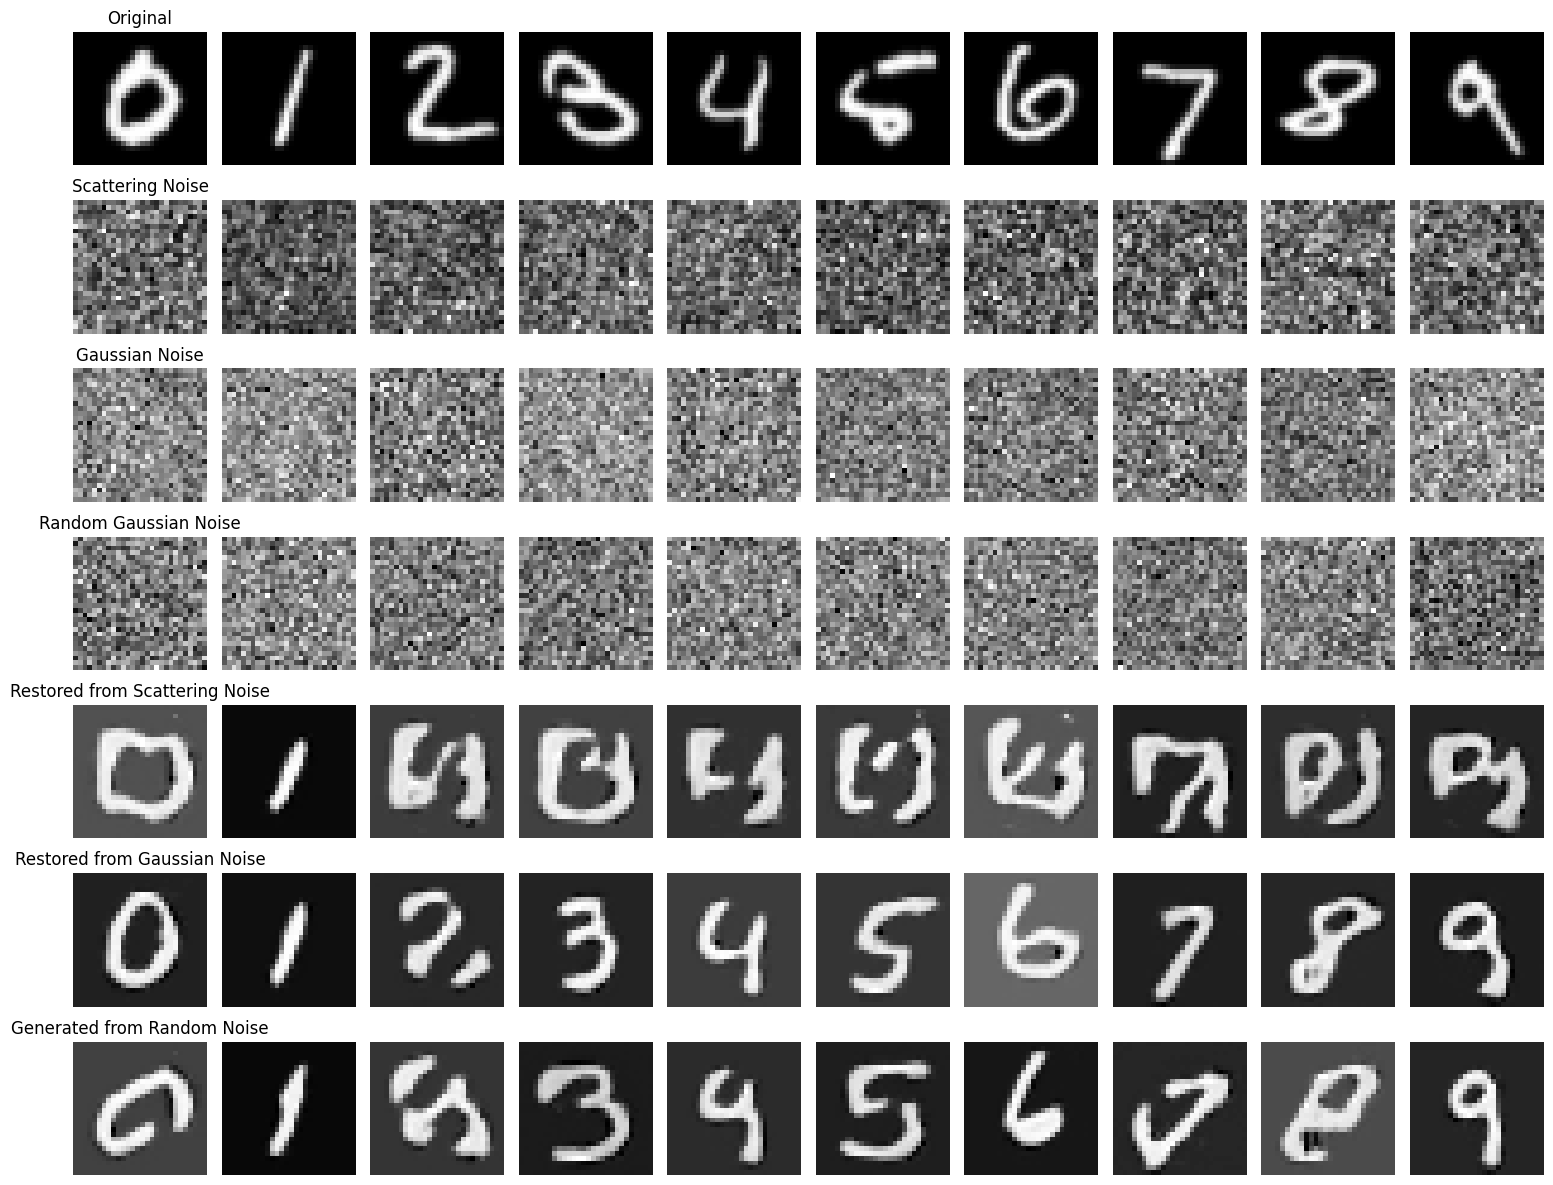

MS = 60, t = 6
스캐터링 노이즈 이미지 - PSNR: 9.55 dB, L2 거리: 9.3373
가우시안 노이즈 이미지 - PSNR: 6.89 dB, L2 거리: 12.6995
랜덤 가우시안 노이즈 - PSNR: -0.30 dB, L2 거리: 29.0110
스캐터링 노이즈 복원 이미지 SSIM: 0.1915
가우시안 노이즈 복원 이미지 SSIM: 0.4533
랜덤 노이즈 복원 이미지 SSIM: 0.2851



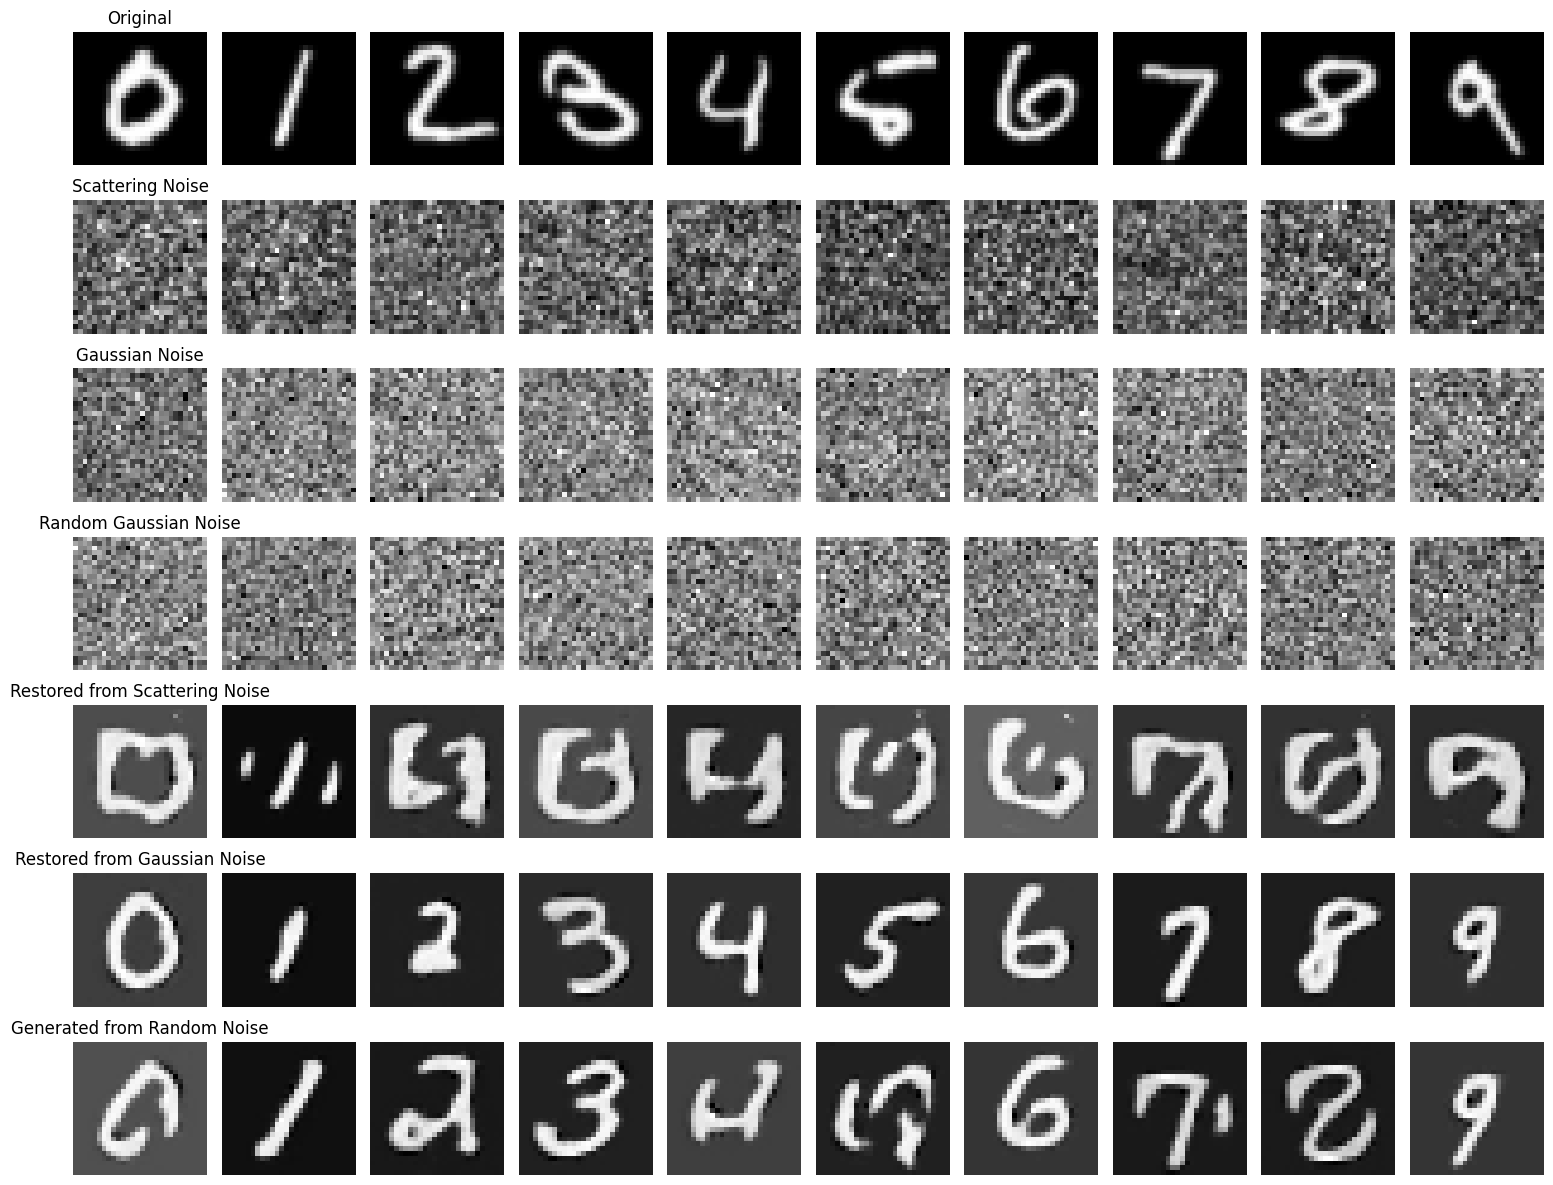

MS = 70, t = 7
스캐터링 노이즈 이미지 - PSNR: 9.23 dB, L2 거리: 9.6949
가우시안 노이즈 이미지 - PSNR: 6.91 dB, L2 거리: 12.6779
랜덤 가우시안 노이즈 - PSNR: -0.28 dB, L2 거리: 28.9407
스캐터링 노이즈 복원 이미지 SSIM: 0.1728
가우시안 노이즈 복원 이미지 SSIM: 0.4111
랜덤 노이즈 복원 이미지 SSIM: 0.2777



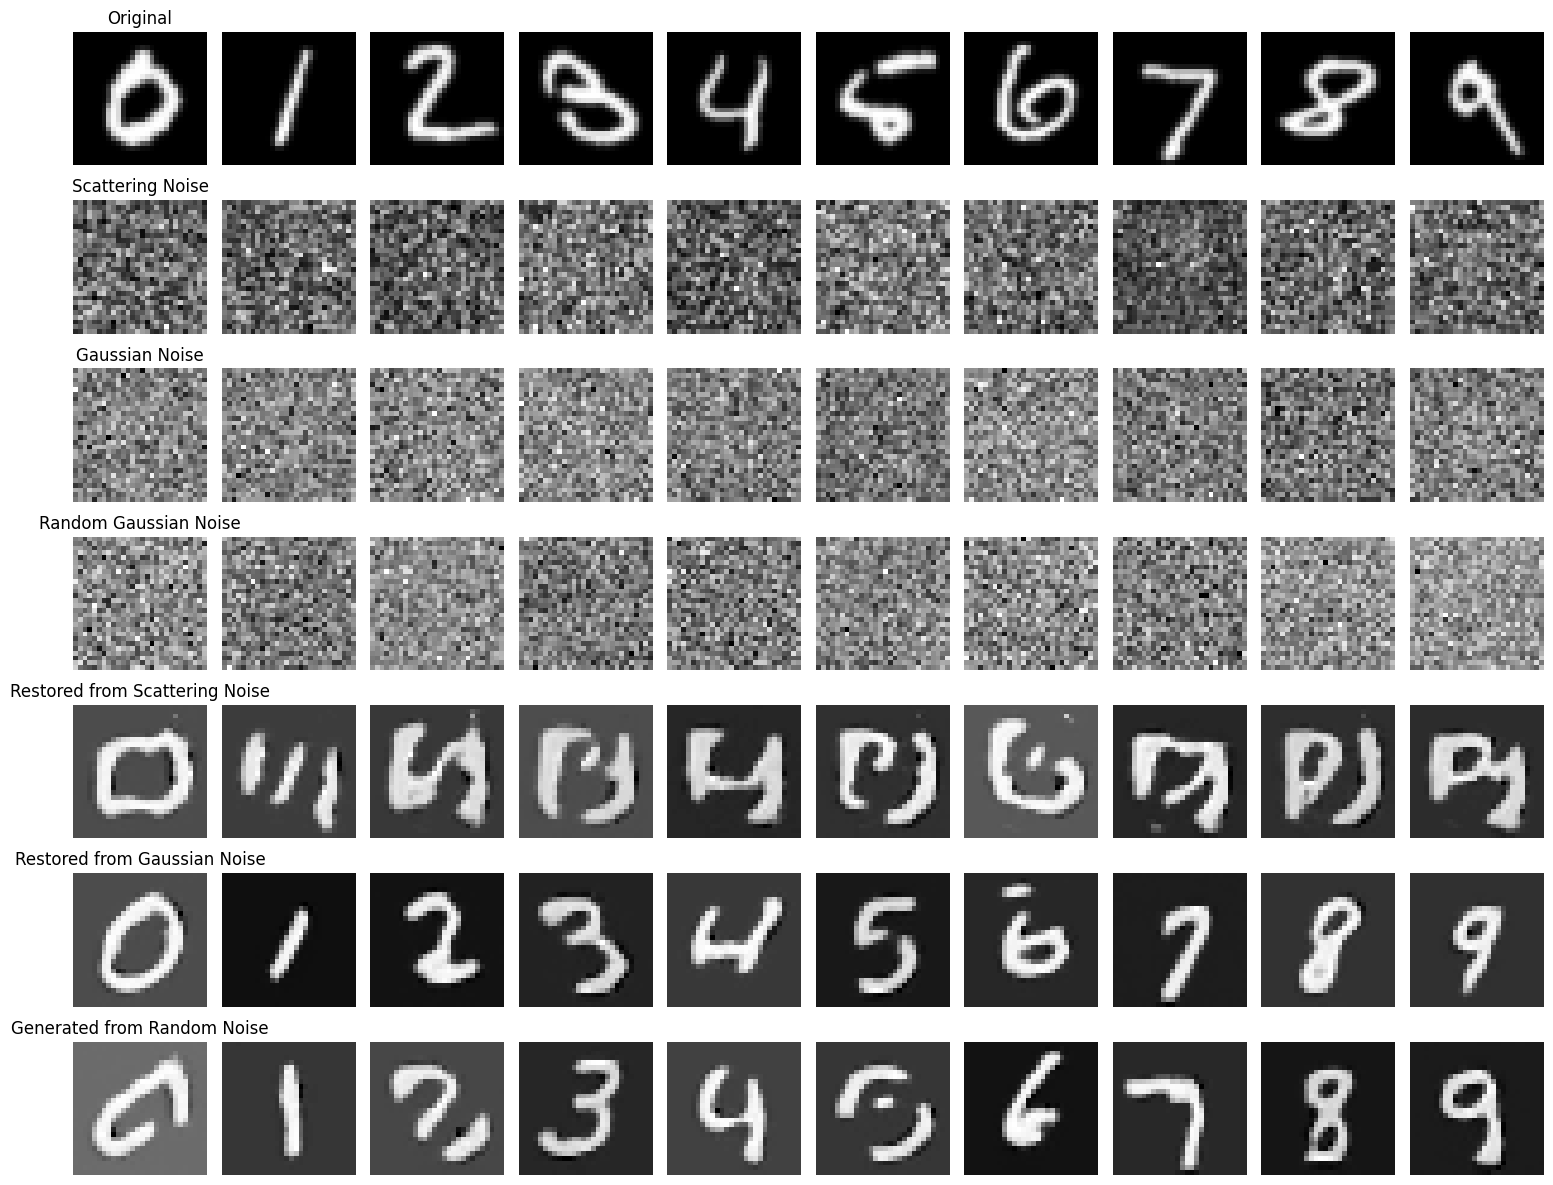

MS = 80, t = 8
스캐터링 노이즈 이미지 - PSNR: 9.30 dB, L2 거리: 9.6144
가우시안 노이즈 이미지 - PSNR: 6.63 dB, L2 거리: 13.0794
랜덤 가우시안 노이즈 - PSNR: -0.45 dB, L2 거리: 29.4996
스캐터링 노이즈 복원 이미지 SSIM: 0.1571
가우시안 노이즈 복원 이미지 SSIM: 0.4124
랜덤 노이즈 복원 이미지 SSIM: 0.2528



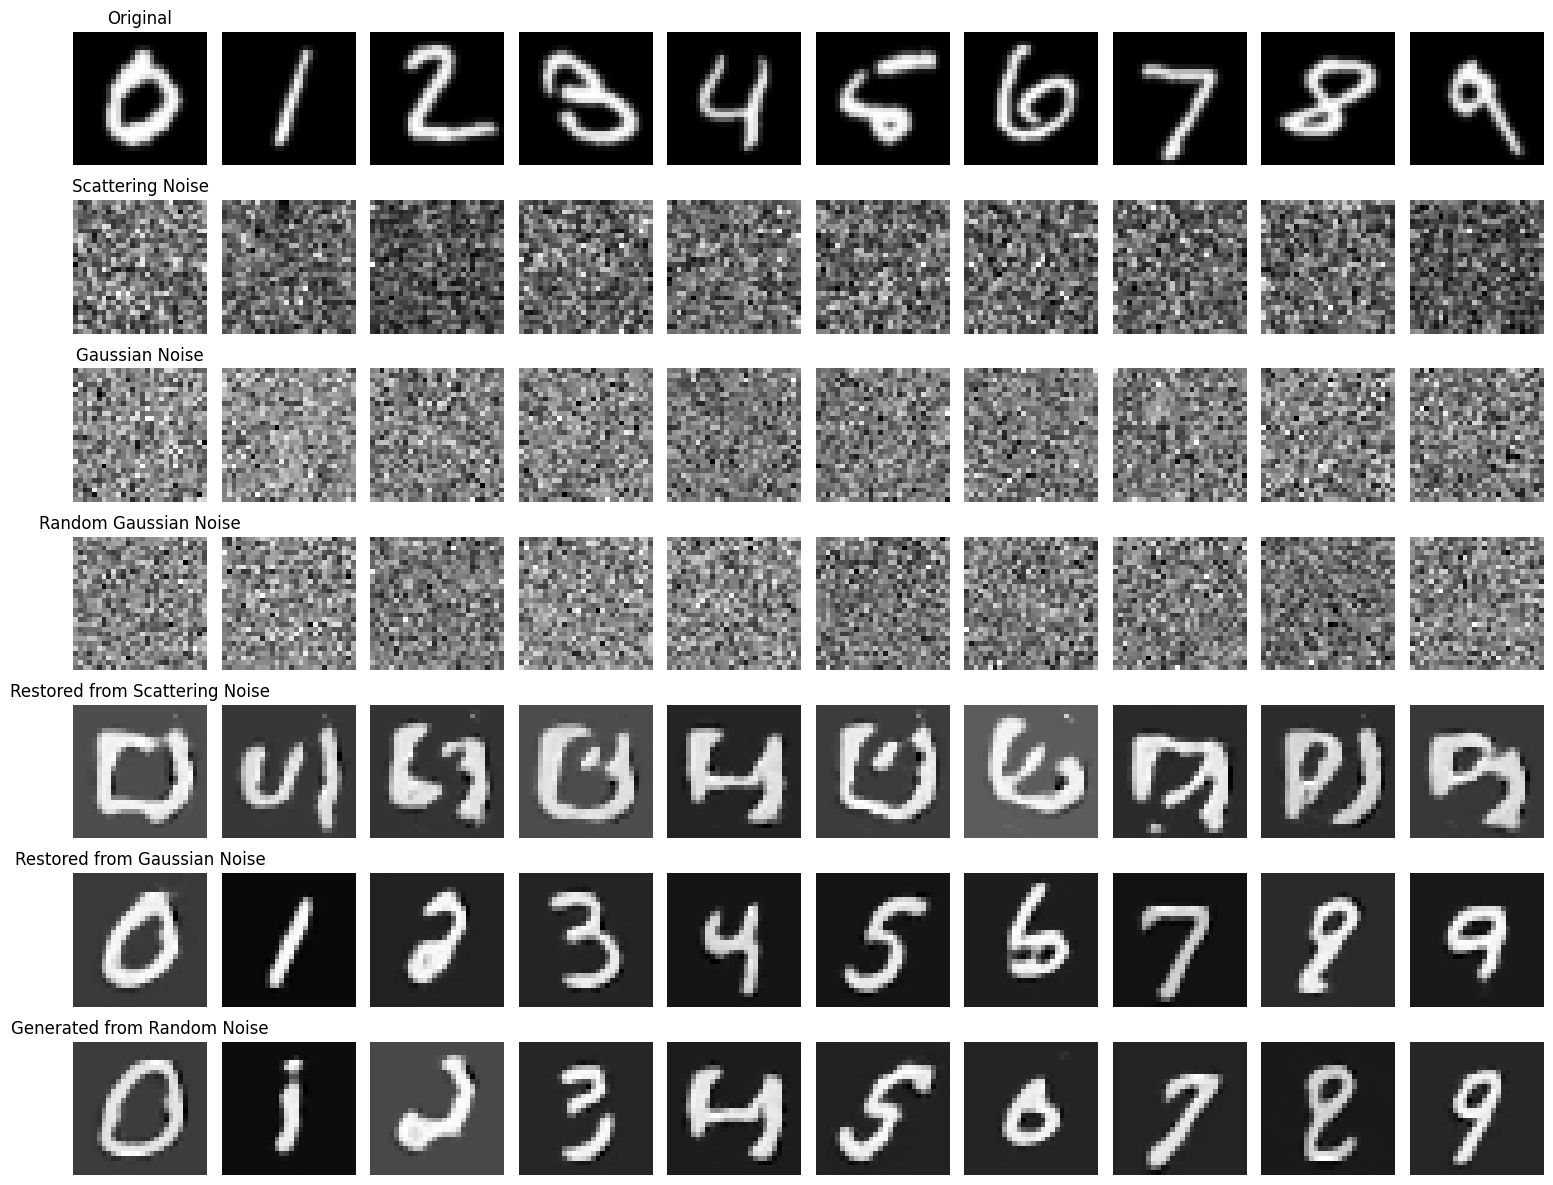

MS = 90, t = 9
스캐터링 노이즈 이미지 - PSNR: 9.40 dB, L2 거리: 9.5066
가우시안 노이즈 이미지 - PSNR: 6.63 dB, L2 거리: 13.0805
랜덤 가우시안 노이즈 - PSNR: -0.33 dB, L2 거리: 29.1004
스캐터링 노이즈 복원 이미지 SSIM: 0.1526
가우시안 노이즈 복원 이미지 SSIM: 0.3459
랜덤 노이즈 복원 이미지 SSIM: 0.2427



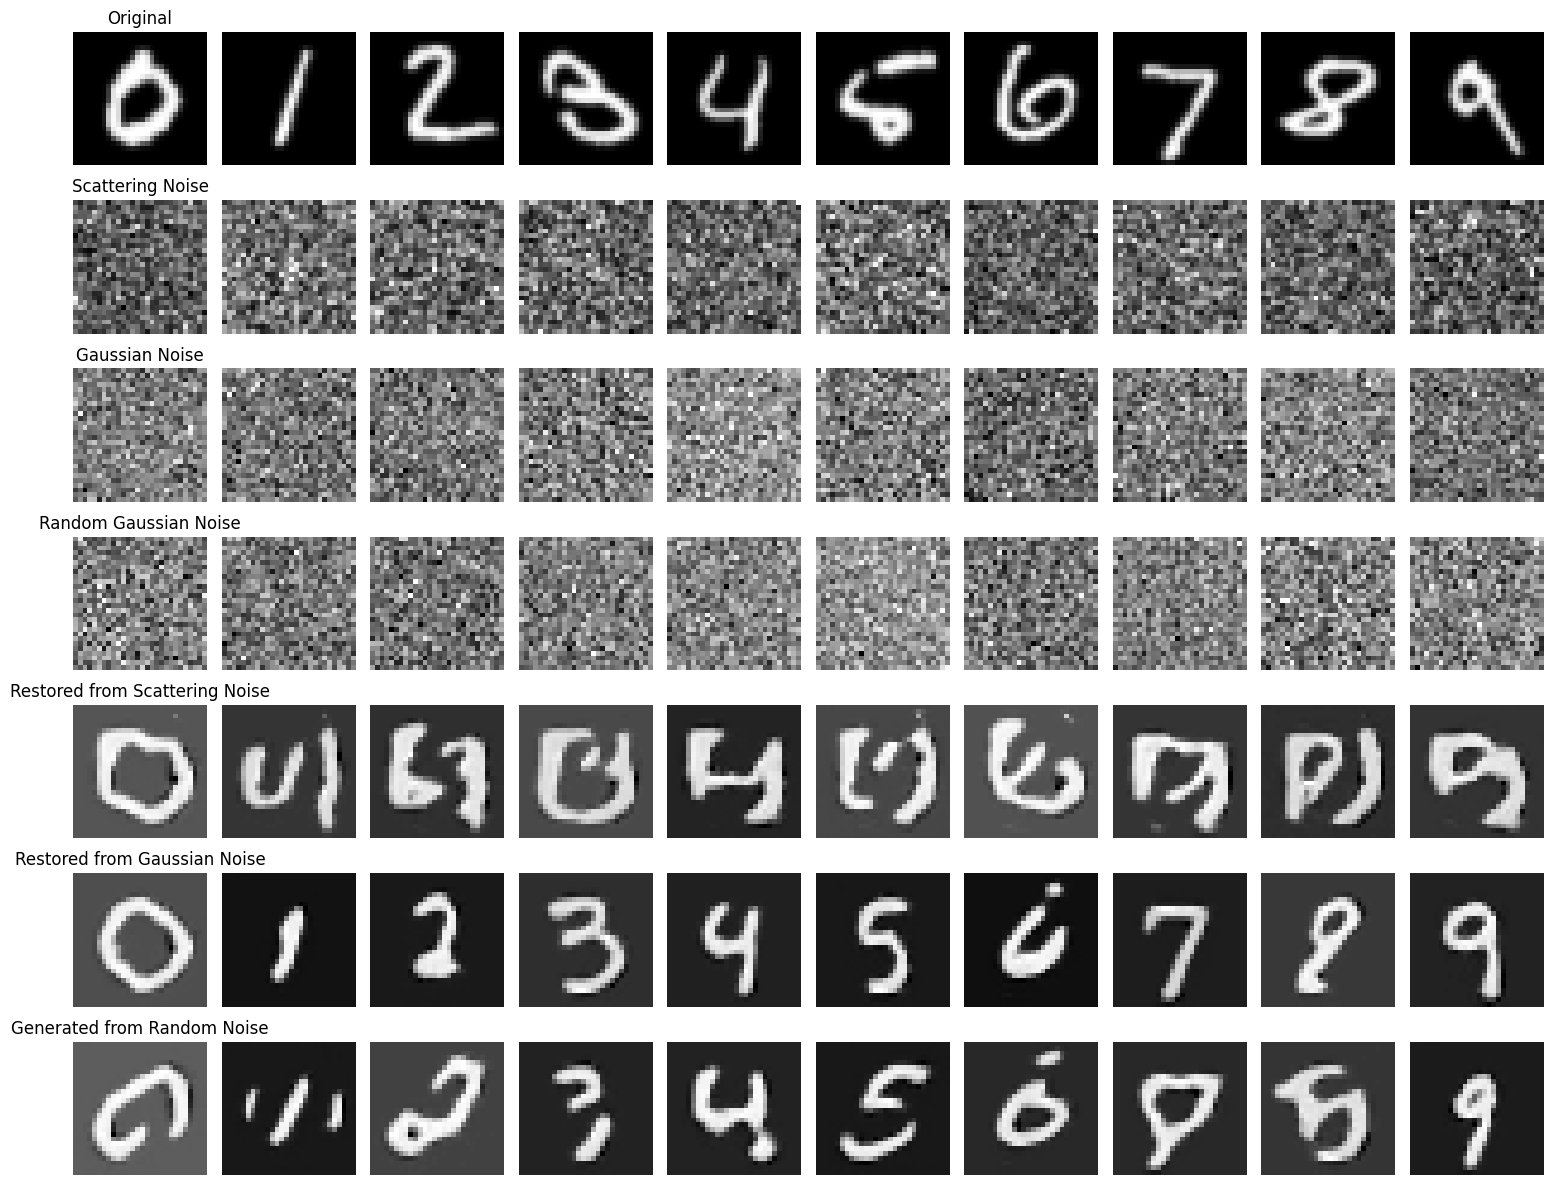

In [185]:
import numpy as np
import matplotlib.pyplot as plt
import torch
import torch.nn.functional as F
from torchvision import datasets, transforms
import cv2
from math import factorial
from skimage.metrics import peak_signal_noise_ratio as psnr
from skimage.metrics import structural_similarity as ssim

# 필요한 함수들 정의 (zernfun, gen_aberration 등)

def zernfun(n, m, r, theta, nflag=None):
    """
    Zernike functions of order N and frequency M on the unit circle.
    """
    # Input validation
    if not (np.ndim(n) == 1 and np.ndim(m) == 1):
        raise ValueError('N and M must be vectors.')

    if len(n) != len(m):
        raise ValueError('N and M must be the same length.')

    n = np.array(n).flatten()
    m = np.array(m).flatten()

    if np.any((n - m) % 2 != 0):
        raise ValueError('All N and M must differ by multiples of 2 (including 0).')

    if np.any(m > n):
        raise ValueError('Each M must be less than or equal to its corresponding N.')

    if np.any((r > 1) | (r < 0)):
        raise ValueError('All R must be between 0 and 1.')

    if not (np.ndim(r) == 1 and np.ndim(theta) == 1):
        raise ValueError('R and THETA must be vectors.')

    r = np.array(r).flatten()
    theta = np.array(theta).flatten()
    length_r = len(r)
    if length_r != len(theta):
        raise ValueError('The number of R- and THETA-values must be equal.')

    # Check normalization
    if nflag is not None and isinstance(nflag, str):
        isnorm = nflag.lower() == 'norm'
        if not isnorm and nflag != '':
            raise ValueError('Unrecognized normalization flag.')
    else:
        isnorm = False

    # Compute the Zernike polynomials
    m_abs = np.abs(m)
    rpowers = []
    for j in range(len(n)):
        rpowers.extend(range(int(m_abs[j]), int(n[j]) + 1, 2))
    rpowers = np.unique(rpowers)

    # Pre-compute the values of r raised to the required powers
    rpowern = np.zeros((length_r, len(rpowers)))
    for idx, p in enumerate(rpowers):
        rpowern[:, idx] = r ** p

    # Compute the values of the polynomials
    z = np.zeros((length_r, len(n)))
    for j in range(len(n)):
        n_j = int(n[j])
        m_abs_j = int(m_abs[j])
        s_max = (n_j - m_abs_j) // 2
        s = np.arange(0, s_max + 1)
        pows = np.arange(n_j, m_abs_j - 1, -2)
        for k in range(len(s)):
            s_k = int(s[k])
            pow_k = int(pows[k])
            numerator = (-1) ** s_k * factorial(n_j - s_k)
            denominator = (factorial(s_k) *
                           factorial((n_j + m_abs_j) // 2 - s_k) *
                           factorial((n_j - m_abs_j) // 2 - s_k))
            p = numerator / denominator
            idx_rpow = np.where(rpowers == pow_k)[0][0]
            z[:, j] += p * rpowern[:, idx_rpow]

        if isnorm:
            z[:, j] *= np.sqrt((1 + (m[j] != 0)) * (n[j] + 1) / np.pi)

    # Compute the Zernike functions
    idx_pos = m > 0
    idx_neg = m < 0

    if np.any(idx_pos):
        z[:, idx_pos] *= np.cos(theta[:, np.newaxis] * m_abs[idx_pos])
    if np.any(idx_neg):
        z[:, idx_neg] *= np.sin(theta[:, np.newaxis] * m_abs[idx_neg])

    return z

def gen_aberration(NA_mask, N_NA, max_value, Max_N):
    """
    Generate aberration phase map and coefficients
    """
    k_index = np.nonzero(NA_mask)
    N_img = NA_mask.shape[0]

    kx, ky = np.meshgrid(np.arange(1, N_img + 1), np.arange(1, N_img + 1))
    kc = np.mean(kx)
    kx = kx.astype(float) - kc
    ky = ky.astype(float) - kc
    kx = kx / float(N_NA)
    ky = ky / float(N_NA)
    kx = kx[k_index]
    ky = ky[k_index]

    N_z = []
    M_z = []
    for n in range(0, Max_N + 1):
        N_z.extend([n] * (n + 1))
        M_z.extend(range(-n, n + 1, 2))

    N_z = np.array(N_z)
    M_z = np.array(M_z)
    theta, rho = np.arctan2(ky, kx), np.hypot(kx, ky)
    z = zernfun(N_z, M_z, rho, theta)
    j_max = z.shape[1]

    z_norm = np.sum(z * z, axis=0)
    for j in range(j_max):
        if M_z[j] == 0:
            epsilon = 2
        else:
            epsilon = 1
        z_norm[j] = z_norm[j] * (2 * N_z[j] + 2) / (epsilon * np.pi)
    z_norm = np.sqrt(z_norm)

    linear_coeff = -max_value * (N_z - Max_N - 1).astype(float) / float(Max_N)
    z_coefficients = linear_coeff * (np.random.rand(j_max) - 0.5)

    z_coefficients[0] = 0  # DC offset

    tmp_map = np.sum(z * (z_coefficients / z_norm), axis=1)
    phase_map = np.zeros((N_img, N_img))
    phase_map[k_index] = tmp_map
    phase_map = (phase_map + np.pi) % (2 * np.pi) - np.pi

    return phase_map, z_coefficients

# MNIST 데이터셋 로드
mnist_testset = datasets.MNIST(root='./data', train=False, download=True,
                               transform=transforms.Compose([transforms.ToTensor()]))

# 각 숫자(0~9)에 대한 첫 번째 이미지를 가져옵니다.
original_images = [None for _ in range(10)]

for img, label in mnist_testset:
    if original_images[label] is None:
        img_np = img.squeeze().numpy()
        original_images[label] = img_np
    if all(image is not None for image in original_images):
        break

# 이미지를 80x80 크기로 리사이즈합니다.
tobj_list = [cv2.resize(img, (80, 80), interpolation=cv2.INTER_LINEAR) for img in original_images]

# 원본 이미지를 텐서로 변환
original_tensors = [torch.tensor(img_np, dtype=torch.float32).unsqueeze(0) for img_np in tobj_list]

# 모델 로드 및 설정
from models.diffusion import MNISTDiffusion

device = "cuda" if torch.cuda.is_available() else "cpu"

model = MNISTDiffusion()
model.load_state_dict(torch.load("mnist_diffusion.dth", map_location=device))
model.to(device)
model.eval()

# 이미지 리사이즈 함수 정의 (스캐터링 노이즈 이미지에만 적용)
def resize_images(image_list, size=(28, 28)):
    resized_images = []
    for img_np in image_list:
        img_resized = cv2.resize(img_np, size, interpolation=cv2.INTER_AREA)
        resized_images.append(torch.tensor(img_resized, dtype=torch.float32).unsqueeze(0))
    return resized_images

# 레이블 생성
class_label = torch.tensor([n for n in range(10)], dtype=torch.long).to(device)

# 이미지 생성 함수
def generate_images(model, noise, labels, start_step=0):
    model.eval()
    generated_images = noise.clone().to(device)
    with torch.no_grad():
        for t in reversed(range(start_step, model.num_steps)):
            generated_images = model(generated_images, labels, t)
    return generated_images

# PSNR, L2 거리 및 SSIM 계산 함수
def calculate_psnr_l2_ssim(original_images, noisy_images, restored_images):
    psnr_values = []
    l2_distances = []
    ssim_values = []

    for orig_img, noisy_img, restored_img in zip(original_images, noisy_images, restored_images):
        # numpy 배열로 변환
        orig_img_np = orig_img.squeeze().cpu().numpy()
        noisy_img_np = noisy_img.squeeze().cpu().numpy()
        restored_img_np = restored_img.squeeze().cpu().numpy()

        # PSNR 계산 (원본 이미지와 노이즈 이미지 간)
        psnr_value = psnr(orig_img_np, noisy_img_np, data_range=1.0)
        psnr_values.append(psnr_value)

        # L2 거리 계산 (원본 이미지와 노이즈 이미지 간)
        l2_distance = np.linalg.norm(orig_img_np - noisy_img_np)
        l2_distances.append(l2_distance)

        # SSIM 계산 (원본 이미지와 복원된 이미지 간)
        ssim_value = ssim(orig_img_np, restored_img_np, data_range=1.0)
        ssim_values.append(ssim_value)

    avg_psnr = np.mean(psnr_values)
    avg_l2_distance = np.mean(l2_distances)
    avg_ssim = np.mean(ssim_values)

    return avg_psnr, avg_l2_distance, avg_ssim

# MS와 t 값을 변경하면서 반복문 실행
MS_values = [0.1,1,5, 20,30,40,50,60,70,80,90]
t_values = [1,1,1,2,3,4,5,6,7,8,9]  # t_values의 길이를 MS_values와 맞추기 위해 1부터 11까지

# 결과를 저장할 리스트
results = []

for MS, t in zip(MS_values, t_values):
    # 스캐터링 노이즈가 추가된 이미지를 저장할 리스트
    noisy_images_fourier = []

    # 가우시안 노이즈가 추가된 이미지를 저장할 리스트
    noisy_images_gaussian = []

    # 완전한 랜덤 가우시안 노이즈를 저장할 리스트
    random_gaussian_noises = []
    generated_images_from_random_noise = []

    # 각 이미지에 대해 처리
    for idx, tobj in enumerate(tobj_list):
        # [00] Data options
        full_opt = 1  # 1600(1), 1264(0)
        basis = 'kx'  # kk, kx, rr

        target_opt = 'lm'

        abin_cpx = 'non'  # rand, non, exrand, (fix)
        about_cpx = 'non'
        about_fact = 10
        abin_fact = 10

        comp_opt = 'reim'  # angle, reim

        sc_opt = 1  # scattering off(0)/on(1)
        # MS 값 설정
        SM = 1 / MS  # single/multi intensity ratio

        # [0] Parameters setup

        NAsz = 20  # radius of pupil [pixel]
        matsz = 4 * NAsz  # [pixel]

        lamb = 0.8  # wavelength [um]
        dx = lamb / 0.4 / 2  # NA resolution
        xtick = dx * np.arange(1, matsz + 1) / 2
        xtick = xtick - np.mean(xtick)

        dk = 2 * 2 * np.pi / dx  # maximum k radius
        ktick = dk / matsz * np.arange(1, matsz + 1)
        ktick = ktick - np.mean(ktick)

        xx, yy = np.meshgrid(np.arange(1, matsz + 1), np.arange(1, matsz + 1))
        rr = (xx - np.mean(xx)) + 1j * (yy - np.mean(yy))

        cmask = np.sqrt((xx - np.mean(xx)) ** 2 + (yy - np.mean(yy)) ** 2) / NAsz
        cmask[cmask <= 1] = 1
        cmask[cmask > 1] = 0

        if full_opt == 1:
            nzind = np.arange(0, (2 * NAsz) ** 2)
        else:
            cmask_crop = cmask[NAsz:3 * NAsz, NAsz:3 * NAsz]
            nzind = np.nonzero(cmask_crop)

        if comp_opt == 'reim':
            data_mat = np.zeros((2 * NAsz, 2 * NAsz, len(nzind) * 2))
            truth_mat = np.zeros((2 * NAsz, 2 * NAsz, 4))

        # Prepare xin-kout (if basis is 'kx')
        if basis == 'kx':
            xinkout = np.zeros(((2 * NAsz) ** 2, (2 * NAsz) ** 2), dtype=complex)
            for ii in range((2 * NAsz) ** 2):
                xin = np.zeros((2 * NAsz, 2 * NAsz), dtype=complex)
                xin.flat[ii] = 1
                tmp = np.fft.ifftshift(np.fft.fft2(np.fft.fftshift(xin)))
                xinkout[:, ii] = tmp.flatten()

        # Continue with the rest of the computation
        xx, yy = np.meshgrid(np.arange(1, 4 * NAsz + 1), np.arange(1, 4 * NAsz + 1))
        re = 2
        cmask2 = np.sqrt((xx - np.mean(xx)) ** 2 + (yy - np.mean(yy)) ** 2) / (re * NAsz)
        cmask2[cmask2 <= 1] = 1
        cmask2[cmask2 > 1] = 0

        target = np.fft.fftshift(np.fft.fft2(tobj))

        cmask = cmask.astype(bool)

        ktarget = target * cmask  # r=40 mask
        ktarget = ktarget[NAsz:3 * NAsz, NAsz:3 * NAsz]

        xtarget = np.fft.ifft2(np.fft.ifftshift(target))

        # Generate kin-kout matrix
        kxtmp, kytmp = np.meshgrid(np.arange(-NAsz, NAsz), np.arange(-NAsz, NAsz))
        kx = kxtmp.flatten()
        ky = kytmp.flatten()
        n1 = (2 * NAsz) ** 2

        Smat = np.zeros((n1, n1), dtype=complex)

        for ii in range(n1):
            tmp = np.roll(np.roll(target, int(kx[ii]), axis=0), int(ky[ii]), axis=1) * cmask
            tmp = tmp[NAsz:3 * NAsz, NAsz:3 * NAsz]
            Smat[:, ii] = tmp.flatten()

        # Create input/output pupil function matrix
        sz = 2 * NAsz
        kx2, ky2 = np.meshgrid(np.arange(1, sz + 1), np.arange(1, sz + 1))
        kc = NAsz + 0.5  # sz / 2 + 0.5
        NA_mask = (kx2 - kc) ** 2 + (ky2 - kc) ** 2 < NAsz ** 2
        roi_NA = np.arange(kc - NAsz, kc + NAsz)
        k_index = np.nonzero(NA_mask)

        ipf = np.zeros((2 * NAsz, 2 * NAsz), dtype=complex)
        opf = np.zeros((2 * NAsz, 2 * NAsz), dtype=complex)

        # Aberration 설정
        if abin_cpx == 'rand':
            abin_fact = 10 + 50 * np.random.rand()  # degree of aberration (10~60)
            ab_phase_map, z_coeff = gen_aberration(NA_mask, NAsz, 50, int(abin_fact))
            ipf[k_index] = np.exp(1j * ab_phase_map[k_index])
        elif abin_cpx == 'non':
            ipf[NA_mask] = 1.0  # no aberration

        if about_cpx == 'rand':
            about_fact = 10 + 50 * np.random.rand()  # degree of aberration (10~60)
            ab_phase_map_opf, z_coeff_opf = gen_aberration(NA_mask, NAsz, 50, int(about_fact))
            opf[k_index] = np.exp(1j * ab_phase_map_opf[k_index])
        elif about_cpx == 'non':
            opf[NA_mask] = 1.0  # no aberration

        # Apply pupil functions
        ipf_flat = ipf.flatten()
        opf_flat = opf.flatten()

        Smat = (opf_flat[:, np.newaxis]) * Smat * (ipf_flat[np.newaxis, :])

        kxmat = Smat
        kxmat = kxmat[:, nzind]

        if basis == 'kx':
            kxmat = kxmat @ xinkout

        if basis == 'rr':
            kxmat = kxmat @ kxmat.T

        if sc_opt == 1:
            chan = kxmat.shape[0]
            Mmat = np.random.randn(chan, chan) + 1j * np.random.randn(chan, chan)

            IM = np.mean(np.sum(np.abs(Mmat) ** 2))
            IS = np.mean(np.sum(np.abs(kxmat) ** 2))

            mat = kxmat * np.sqrt(IM / IS * SM) + Mmat
            kxmat = mat[:, nzind]
        else:
            kxmat = kxmat[:, nzind]

        # 복소수 데이터 복원
        num_channels = kxmat.shape[1]

        complex_image = np.zeros((2 * NAsz, 2 * NAsz), dtype=complex)

        for i in range(num_channels):
            complex_image += kxmat[:, i].reshape(2 * NAsz, 2 * NAsz)

        # 역변환하여 이미지 복원
        reconstructed_image = np.fft.ifft2(complex_image)

        # 실수부를 취하고 정규화
        reconstructed_magnitude = np.abs(reconstructed_image)
        reconstructed_magnitude /= np.max(reconstructed_magnitude)

        # 스캐터링 노이즈가 추가된 이미지를 저장
        noisy_image_fourier = reconstructed_magnitude.astype(np.float32)
        noisy_images_fourier.append(noisy_image_fourier)

        # 가우시안 노이즈 추가 부분 수정: 모델의 Forward Diffusion Process 사용
        # 이미지를 28x28로 리사이즈하고 텐서로 변환
        img_resized = cv2.resize(tobj, (28, 28), interpolation=cv2.INTER_AREA)
        img_tensor = torch.tensor(img_resized, dtype=torch.float32).unsqueeze(0).unsqueeze(0).to(device)

        # 노이즈 단계 설정
        t_noise = t

        # Forward Diffusion Process를 통해 노이즈 추가
        noisy_image = img_tensor.clone()
        with torch.no_grad():
            for step in range(t_noise):
                noisy_image = model(noisy_image, backward=False)

        # 노이즈가 추가된 이미지를 저장
        noisy_images_gaussian.append(noisy_image.cpu().squeeze(0))

        # 완전한 랜덤 가우시안 노이즈 생성
        random_noise = torch.randn_like(img_tensor).cpu().squeeze(0)
        random_gaussian_noises.append(random_noise)

    # 스캐터링 노이즈 이미지를 리사이즈하고 텐서로 변환
    noisy_images_fourier_tensors = resize_images(noisy_images_fourier)

    # 원본 이미지를 리사이즈하고 텐서로 변환
    original_tensors_resized = resize_images([img.squeeze().numpy() for img in original_tensors])

    # 결과를 시각화하기 위해 리스트를 준비
    original = original_tensors_resized
    noisy_images_fourier = noisy_images_fourier_tensors

    # 가우시안 노이즈 이미지는 이미 텐서로 변환되어 있으므로 그대로 사용
    noisy_images_gaussian_tensors = noisy_images_gaussian

    # 완전한 랜덤 가우시안 노이즈로부터 이미지 생성
    random_gaussian_noise_tensor = torch.stack(random_gaussian_noises).to(device)
    result_random_noise = generate_images(model, random_gaussian_noise_tensor, class_label, start_step=1).cpu().detach()
    generated_images_from_random_noise = result_random_noise

    # 스캐터링 노이즈 이미지로부터 결과 생성
    noisy_images_fourier_tensor = torch.stack(noisy_images_fourier).to(device)
    result_fourier = generate_images(model, noisy_images_fourier_tensor, class_label, start_step = model.num_steps - t).cpu().detach()

    # 가우시안 노이즈 이미지로부터 결과 생성
    noisy_images_gaussian_tensor = torch.stack(noisy_images_gaussian_tensors).to(device)
    result_gaussian = generate_images(model, noisy_images_gaussian_tensor, class_label, start_step = model.num_steps - t).cpu().detach()

    # PSNR, L2 거리 및 SSIM 계산
    avg_psnr_fourier, avg_l2_fourier, avg_ssim_fourier = calculate_psnr_l2_ssim(original, noisy_images_fourier, result_fourier)
    avg_psnr_gaussian, avg_l2_gaussian, avg_ssim_gaussian = calculate_psnr_l2_ssim(original, noisy_images_gaussian_tensors, result_gaussian)
    avg_psnr_random, avg_l2_random, avg_ssim_random = calculate_psnr_l2_ssim(original, random_gaussian_noises, generated_images_from_random_noise)

    # 결과 출력
    print(f"MS = {MS}, t = {t}")
    print(f"스캐터링 노이즈 이미지 - PSNR: {avg_psnr_fourier:.2f} dB, L2 거리: {avg_l2_fourier:.4f}")
    print(f"가우시안 노이즈 이미지 - PSNR: {avg_psnr_gaussian:.2f} dB, L2 거리: {avg_l2_gaussian:.4f}")
    print(f"랜덤 가우시안 노이즈 - PSNR: {avg_psnr_random:.2f} dB, L2 거리: {avg_l2_random:.4f}")
    print(f"스캐터링 노이즈 복원 이미지 SSIM: {avg_ssim_fourier:.4f}")
    print(f"가우시안 노이즈 복원 이미지 SSIM: {avg_ssim_gaussian:.4f}")
    print(f"랜덤 노이즈 복원 이미지 SSIM: {avg_ssim_random:.4f}\n")

    # 결과를 저장
    results.append({
        'MS': MS,
        't': t,
        'PSNR_Fourier': avg_psnr_fourier,
        'L2_Fourier': avg_l2_fourier,
        'SSIM_Restored_Fourier': avg_ssim_fourier,
        'PSNR_Gaussian': avg_psnr_gaussian,
        'L2_Gaussian': avg_l2_gaussian,
        'SSIM_Restored_Gaussian': avg_ssim_gaussian,
        'PSNR_Random': avg_psnr_random,
        'L2_Random': avg_l2_random,
        'SSIM_Restored_Random': avg_ssim_random
    })

    # 결과 시각화
    fig, ax = plt.subplots(nrows=7, ncols=10, figsize=(15, 12))

    # 원본 이미지 시각화
    for i, image in enumerate(original):
        ax[0, i].imshow(image.squeeze(), cmap="gray")
        ax[0, i].axis("off")
        if i == 0:
            ax[0, i].set_title("Original")

    # 스캐터링 노이즈 이미지 시각화
    for i, image in enumerate(noisy_images_fourier):
        ax[1, i].imshow(image.squeeze(), cmap="gray")
        ax[1, i].axis("off")
        if i == 0:
            ax[1, i].set_title("Scattering Noise")

    # 가우시안 노이즈 이미지 시각화
    for i, image in enumerate(noisy_images_gaussian_tensors):
        ax[2, i].imshow(image.squeeze(), cmap="gray")
        ax[2, i].axis("off")
        if i == 0:
            ax[2, i].set_title("Gaussian Noise")

    # 랜덤 가우시안 노이즈 시각화
    for i, image in enumerate(random_gaussian_noises):
        ax[3, i].imshow(image.squeeze(), cmap="gray")
        ax[3, i].axis("off")
        if i == 0:
            ax[3, i].set_title("Random Gaussian Noise")

    # 스캐터링 노이즈 이미지로부터 생성된 결과 시각화
    for i, image in enumerate(result_fourier):
        ax[4, i].imshow(image.squeeze(), cmap="gray")
        ax[4, i].axis("off")
        if i == 0:
            ax[4, i].set_title("Restored from Scattering Noise")
    # 가우시안 노이즈 이미지로부터 생성된 결과 시각화
    for i, image in enumerate(result_gaussian):
        ax[5, i].imshow(image.squeeze(), cmap="gray")
        ax[5, i].axis("off")
        if i == 0:
            ax[5, i].set_title("Restored from Gaussian Noise")
    # 랜덤 가우시안 노이즈로부터 생성된 결과 시각화
    for i, image in enumerate(generated_images_from_random_noise):
        ax[6, i].imshow(image.squeeze(), cmap="gray")
        ax[6, i].axis("off")
        if i == 0:
            ax[6, i].set_title("Generated from Random Noise")

    plt.tight_layout()
    plt.show()


data

<ipython-input-194-a185664fa2cd>:173: FutureWarning: You are using `torch.load` with `weights_only=False` (the current default value), which uses the default pickle module implicitly. It is possible to construct malicious pickle data which will execute arbitrary code during unpickling (See https://github.com/pytorch/pytorch/blob/main/SECURITY.md#untrusted-models for more details). In a future release, the default value for `weights_only` will be flipped to `True`. This limits the functions that could be executed during unpickling. Arbitrary objects will no longer be allowed to be loaded via this mode unless they are explicitly allowlisted by the user via `torch.serialization.add_safe_globals`. We recommend you start setting `weights_only=True` for any use case where you don't have full control of the loaded file. Please open an issue on GitHub for any issues related to this experimental feature.
  model.load_state_dict(torch.load("mnist_diffusion.dth", map_location=device))


MS = 0.1, t = 1
스캐터링 노이즈 이미지 - PSNR: 18.99 dB, L2 거리: 3.2321
가우시안 노이즈 이미지 - PSNR: 11.86 dB, L2 거리: 7.1527
랜덤 가우시안 노이즈 - PSNR: -0.22 dB, L2 거리: 28.7348
스캐터링 노이즈 복원 이미지 SSIM: 0.8216
가우시안 노이즈 복원 이미지 SSIM: 0.8336
랜덤 노이즈 복원 이미지 SSIM: 0.2422



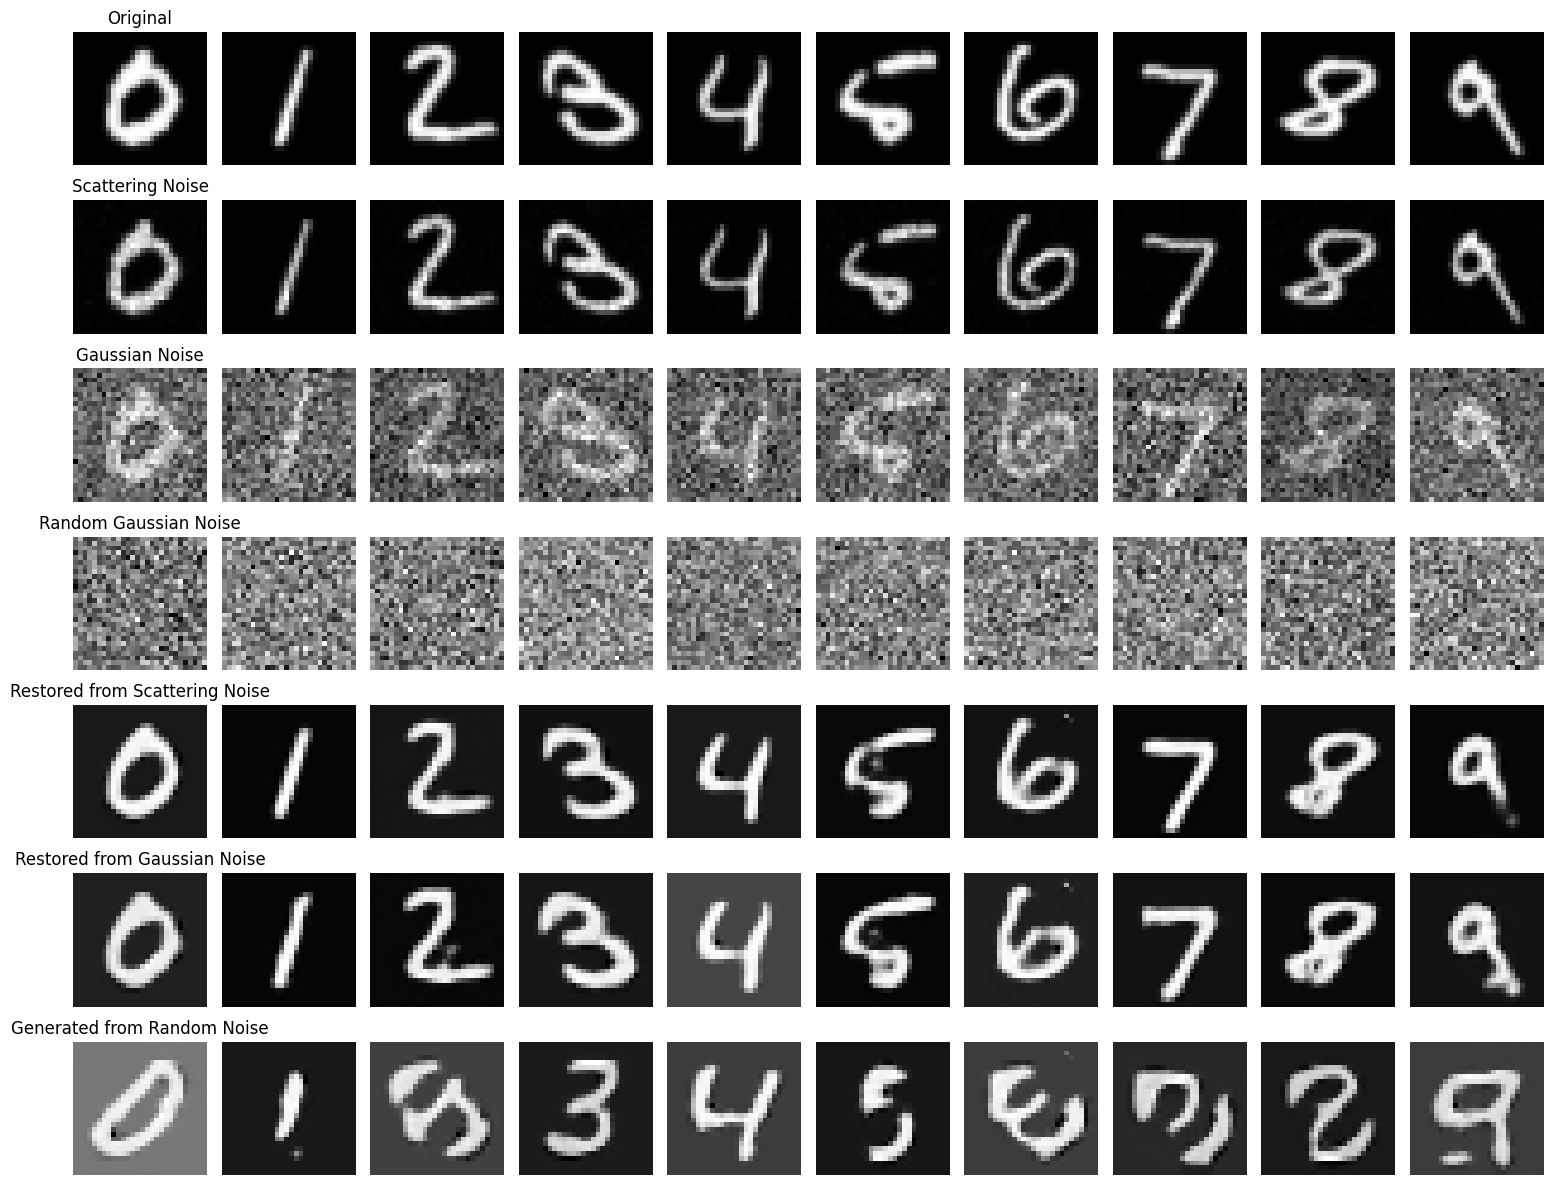

MS = 1, t = 1
스캐터링 노이즈 이미지 - PSNR: 15.31 dB, L2 거리: 4.9876
가우시안 노이즈 이미지 - PSNR: 11.66 dB, L2 거리: 7.3159
랜덤 가우시안 노이즈 - PSNR: -0.38 dB, L2 거리: 29.2711
스캐터링 노이즈 복원 이미지 SSIM: 0.7498
가우시안 노이즈 복원 이미지 SSIM: 0.8202
랜덤 노이즈 복원 이미지 SSIM: 0.2907



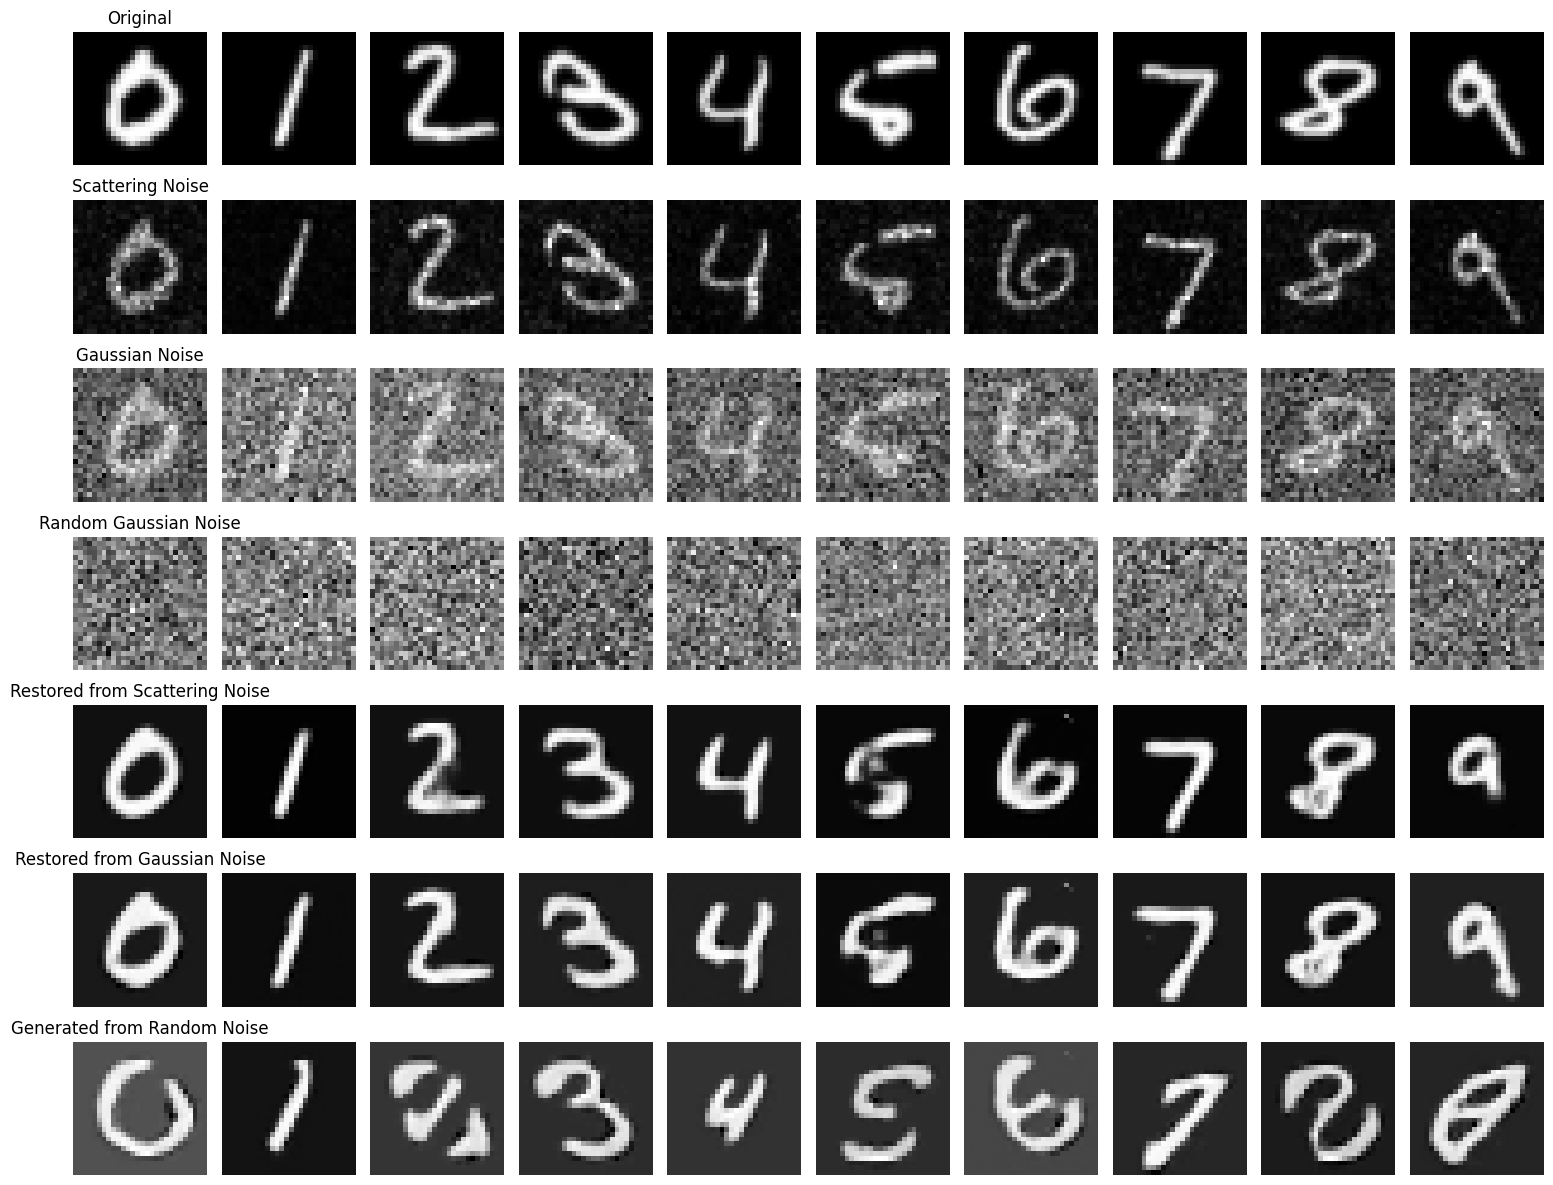

MS = 5, t = 1
스캐터링 노이즈 이미지 - PSNR: 13.07 dB, L2 거리: 6.4210
가우시안 노이즈 이미지 - PSNR: 11.67 dB, L2 거리: 7.3110
랜덤 가우시안 노이즈 - PSNR: -0.23 dB, L2 거리: 28.7566
스캐터링 노이즈 복원 이미지 SSIM: 0.6007
가우시안 노이즈 복원 이미지 SSIM: 0.8333
랜덤 노이즈 복원 이미지 SSIM: 0.3815



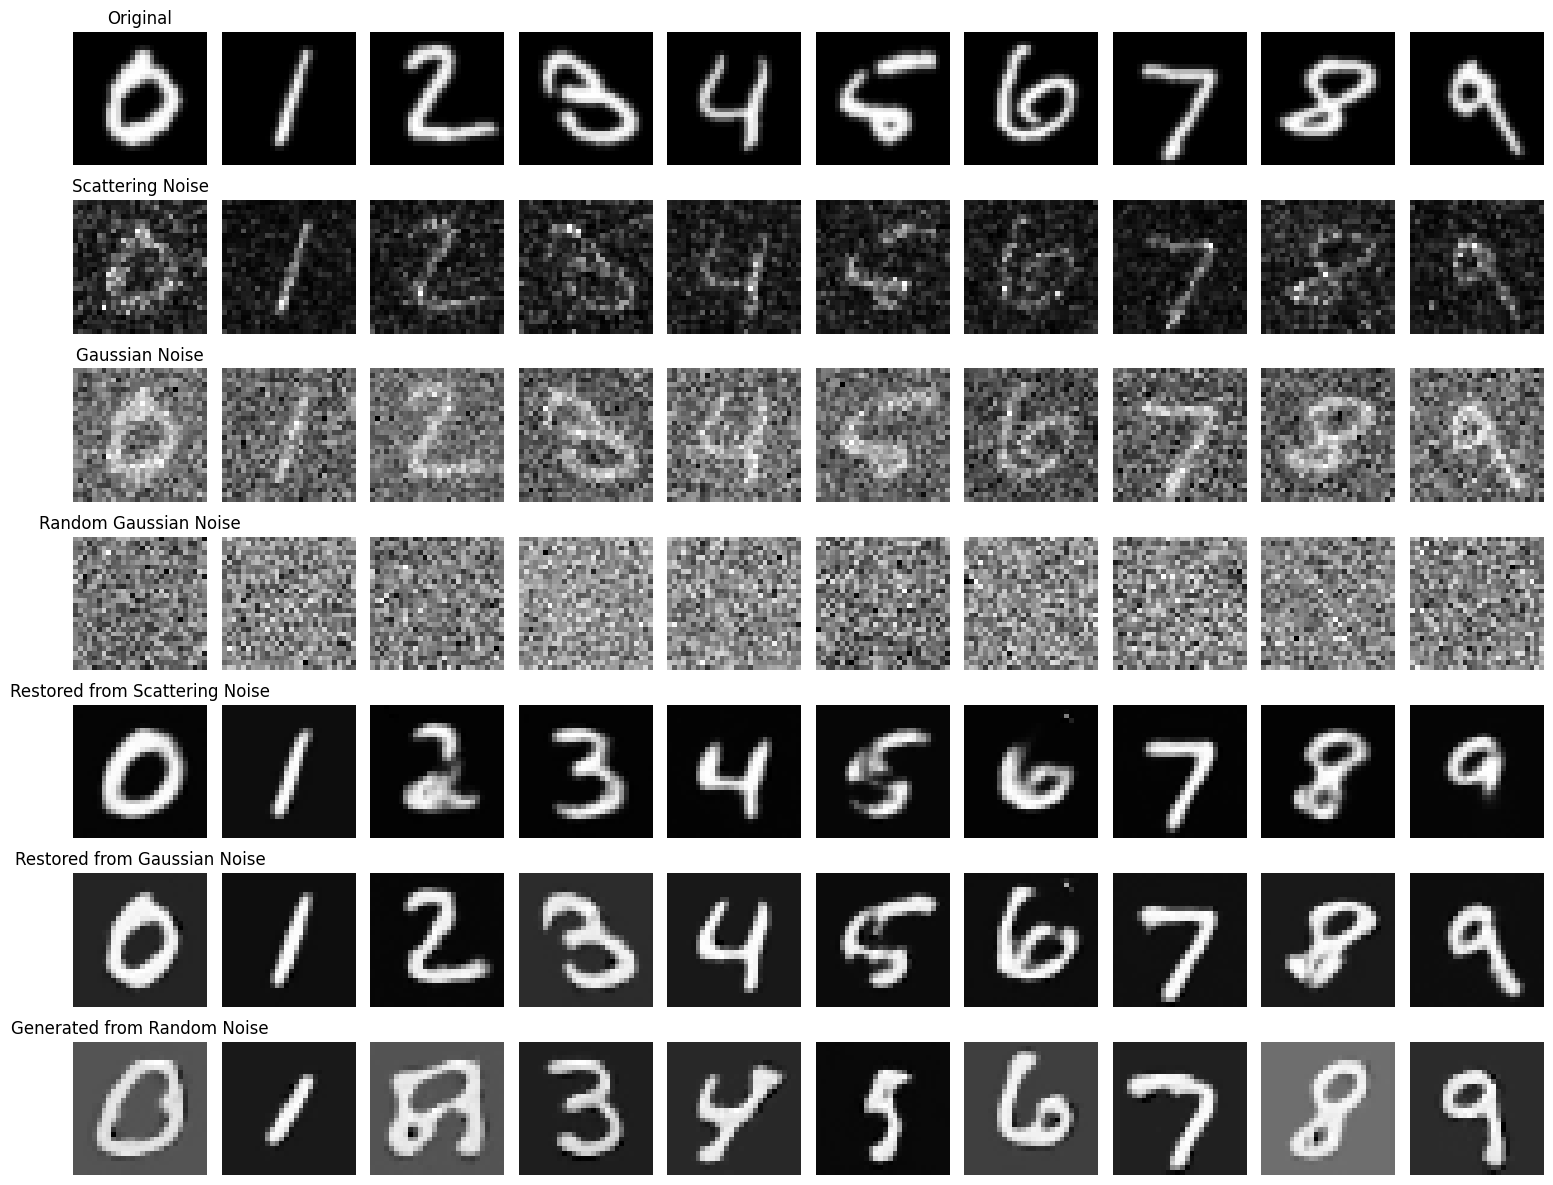

MS = 20, t = 2
스캐터링 노이즈 이미지 - PSNR: 11.70 dB, L2 거리: 7.3999
가우시안 노이즈 이미지 - PSNR: 9.37 dB, L2 거리: 9.5210
랜덤 가우시안 노이즈 - PSNR: -0.43 dB, L2 거리: 29.4369
스캐터링 노이즈 복원 이미지 SSIM: 0.4791
가우시안 노이즈 복원 이미지 SSIM: 0.7371
랜덤 노이즈 복원 이미지 SSIM: 0.2729



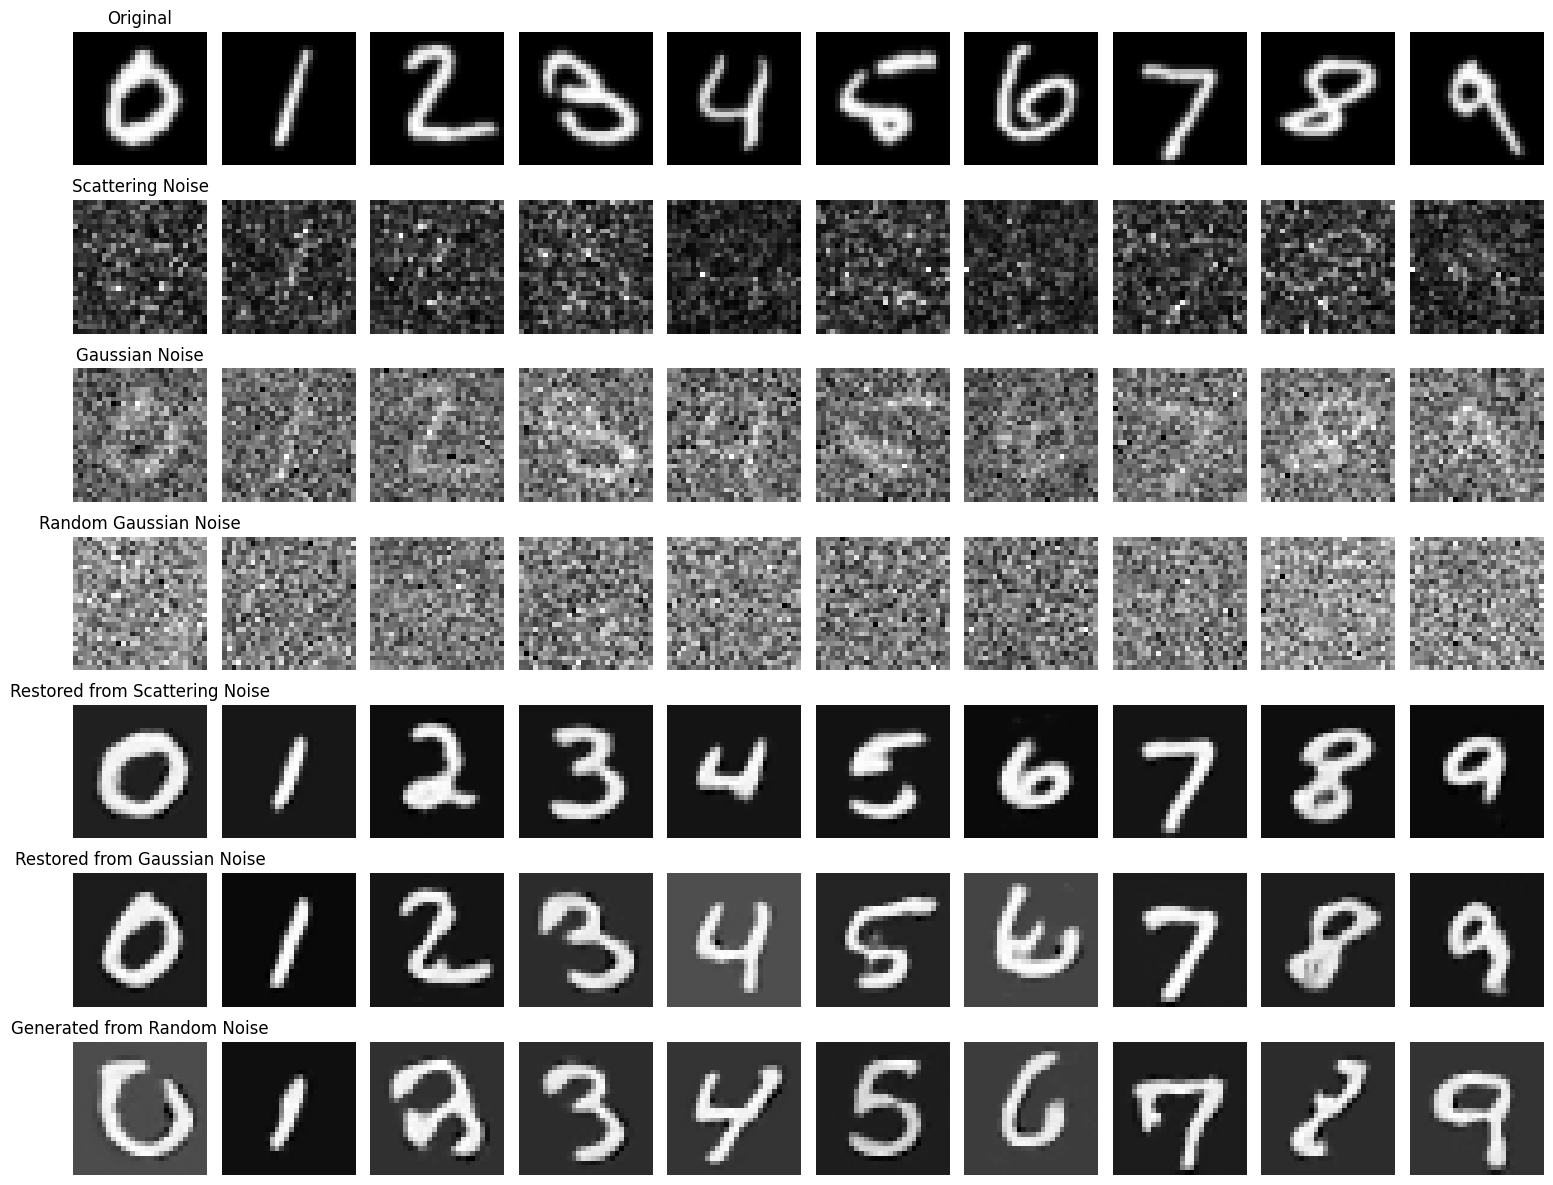

MS = 30, t = 3
스캐터링 노이즈 이미지 - PSNR: 11.54 dB, L2 거리: 7.5521
가우시안 노이즈 이미지 - PSNR: 8.21 dB, L2 거리: 10.8952
랜덤 가우시안 노이즈 - PSNR: -0.30 dB, L2 거리: 29.0014
스캐터링 노이즈 복원 이미지 SSIM: 0.4554
가우시안 노이즈 복원 이미지 SSIM: 0.6466
랜덤 노이즈 복원 이미지 SSIM: 0.2986



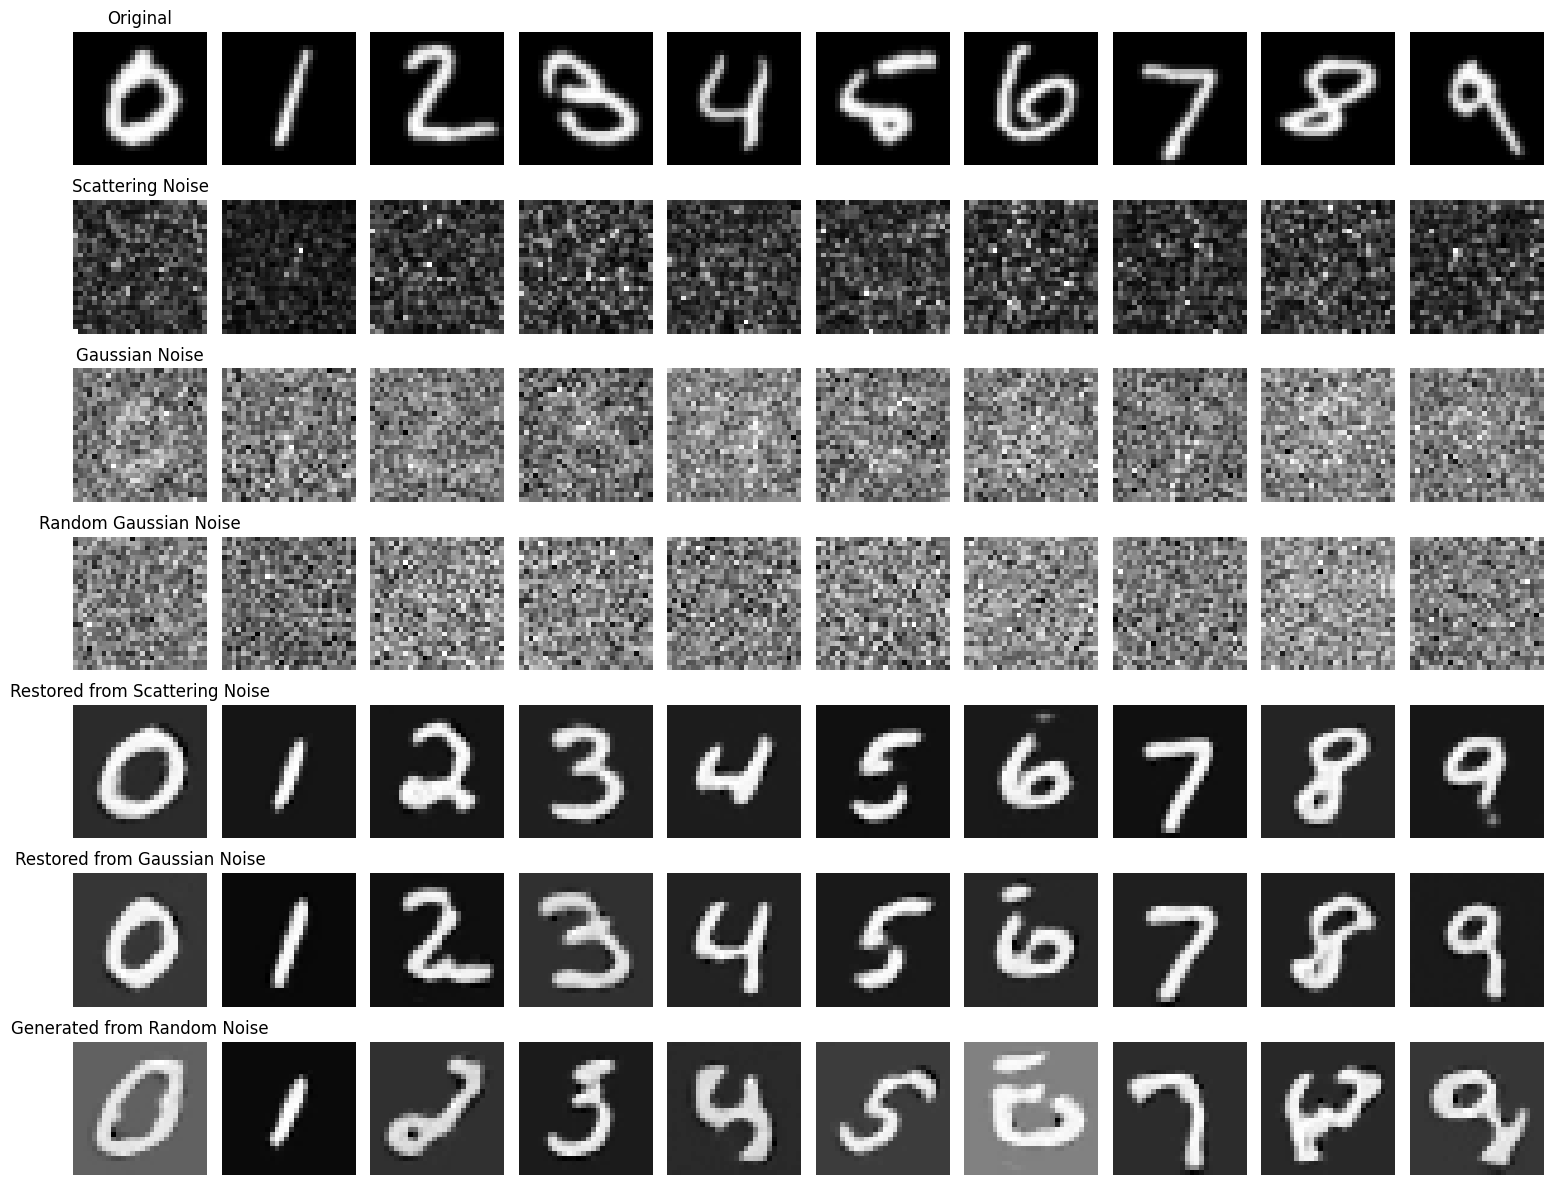

MS = 40, t = 4
스캐터링 노이즈 이미지 - PSNR: 11.39 dB, L2 거리: 7.6682
가우시안 노이즈 이미지 - PSNR: 7.62 dB, L2 거리: 11.6639
랜덤 가우시안 노이즈 - PSNR: -0.44 dB, L2 거리: 29.4692
스캐터링 노이즈 복원 이미지 SSIM: 0.4226
가우시안 노이즈 복원 이미지 SSIM: 0.6185
랜덤 노이즈 복원 이미지 SSIM: 0.3010



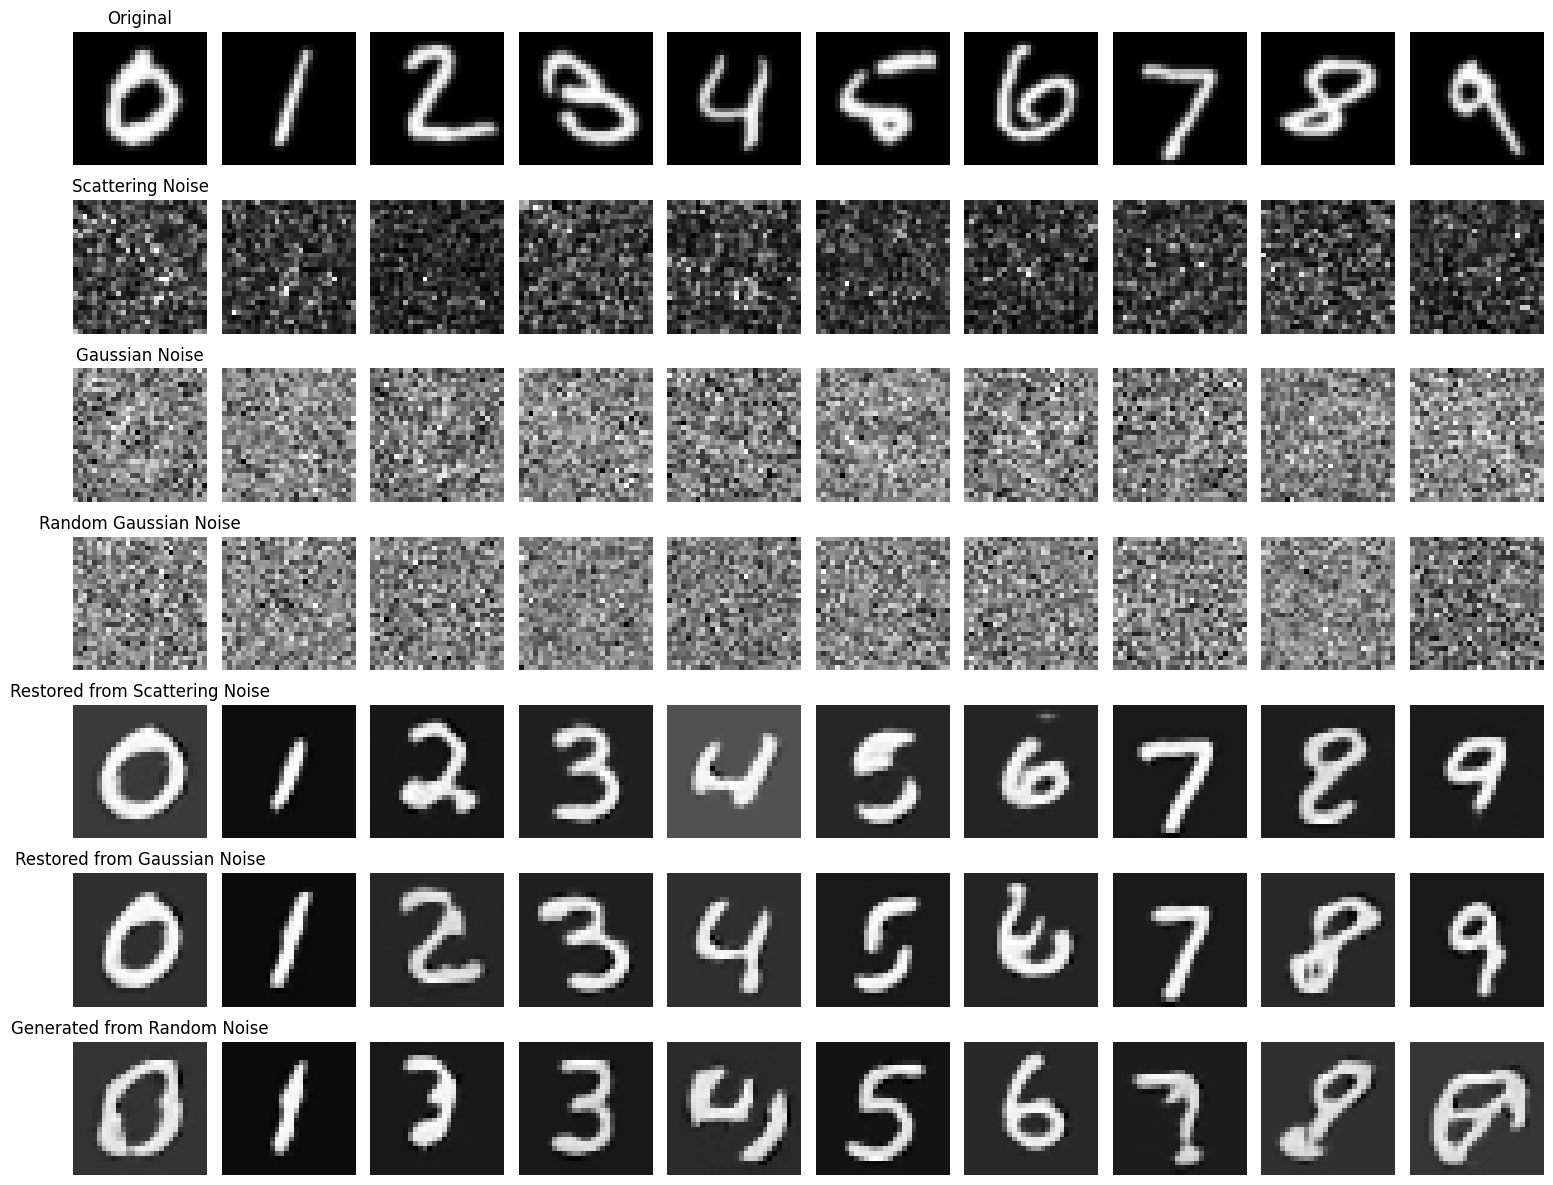

MS = 50, t = 5
스캐터링 노이즈 이미지 - PSNR: 11.26 dB, L2 거리: 7.7763
가우시안 노이즈 이미지 - PSNR: 7.26 dB, L2 거리: 12.1495
랜덤 가우시안 노이즈 - PSNR: -0.37 dB, L2 거리: 29.2501
스캐터링 노이즈 복원 이미지 SSIM: 0.3935
가우시안 노이즈 복원 이미지 SSIM: 0.4912
랜덤 노이즈 복원 이미지 SSIM: 0.3697



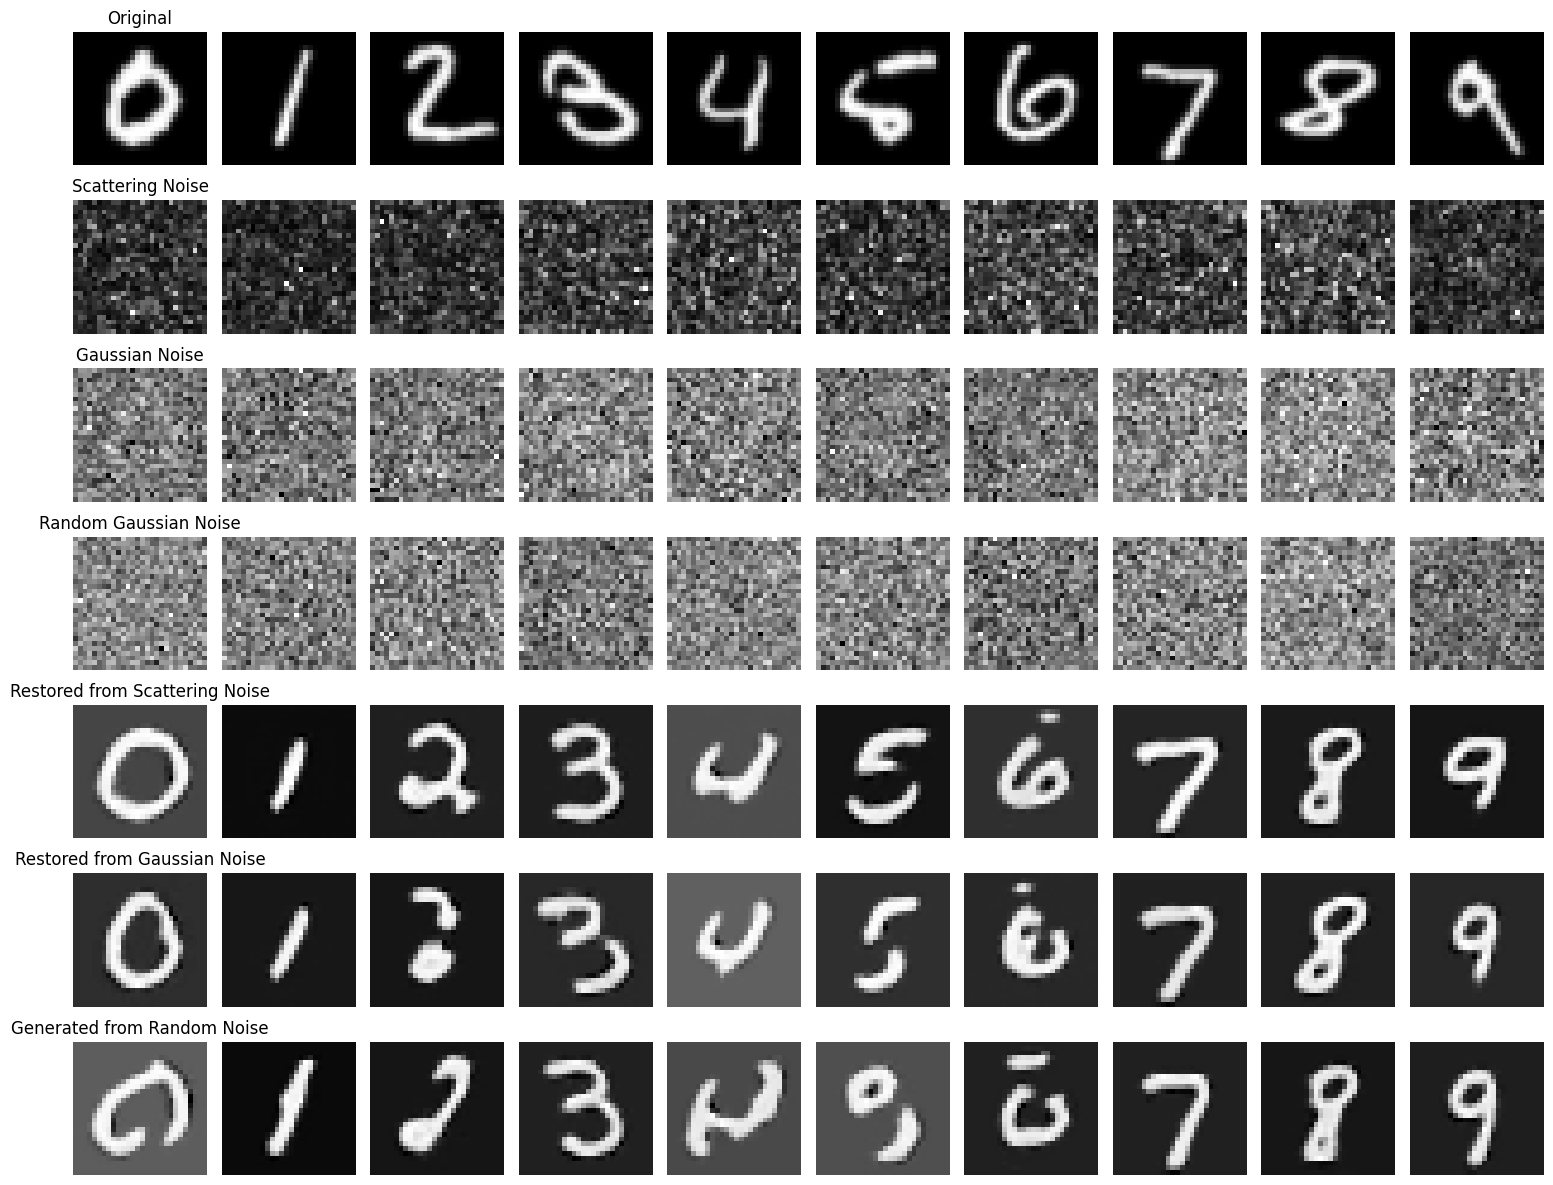

MS = 60, t = 6
스캐터링 노이즈 이미지 - PSNR: 11.22 dB, L2 거리: 7.7957
가우시안 노이즈 이미지 - PSNR: 6.94 dB, L2 거리: 12.6208
랜덤 가우시안 노이즈 - PSNR: -0.46 dB, L2 거리: 29.5352
스캐터링 노이즈 복원 이미지 SSIM: 0.4255
가우시안 노이즈 복원 이미지 SSIM: 0.5024
랜덤 노이즈 복원 이미지 SSIM: 0.3568



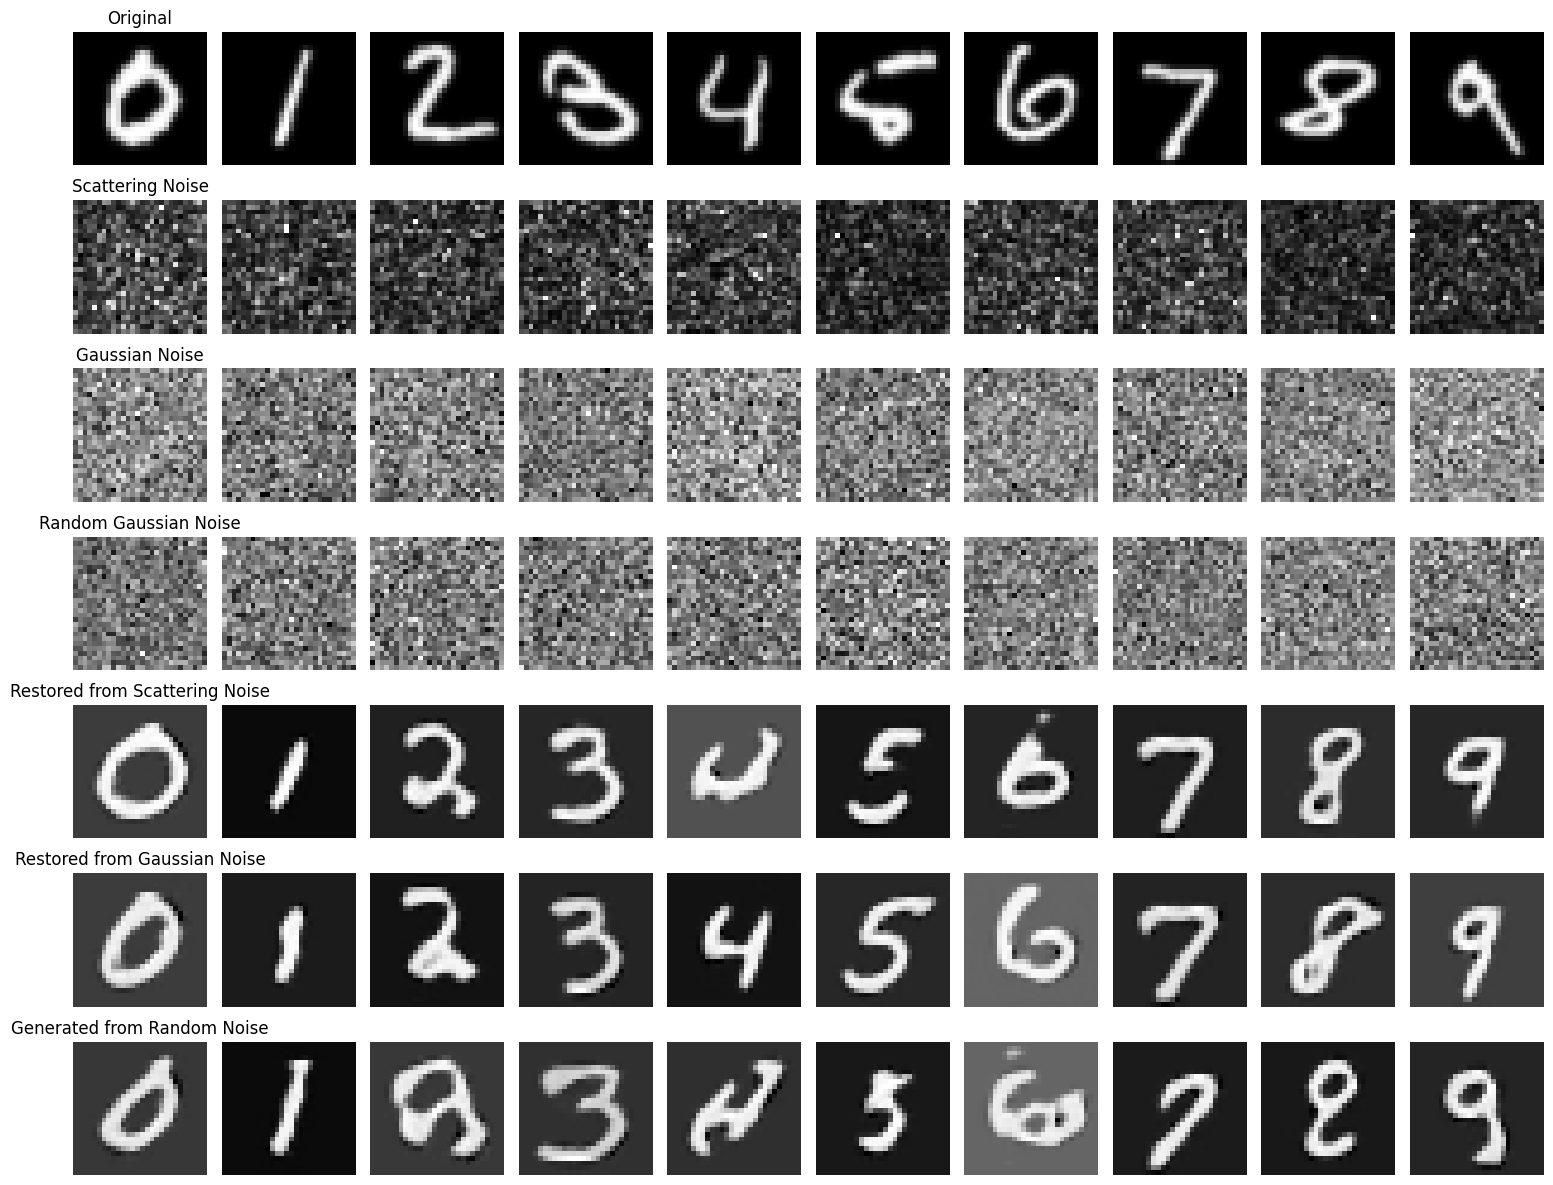

MS = 70, t = 7
스캐터링 노이즈 이미지 - PSNR: 11.22 dB, L2 거리: 7.7950
가우시안 노이즈 이미지 - PSNR: 6.83 dB, L2 거리: 12.7783
랜덤 가우시안 노이즈 - PSNR: -0.36 dB, L2 거리: 29.1862
스캐터링 노이즈 복원 이미지 SSIM: 0.3782
가우시안 노이즈 복원 이미지 SSIM: 0.4394
랜덤 노이즈 복원 이미지 SSIM: 0.2629



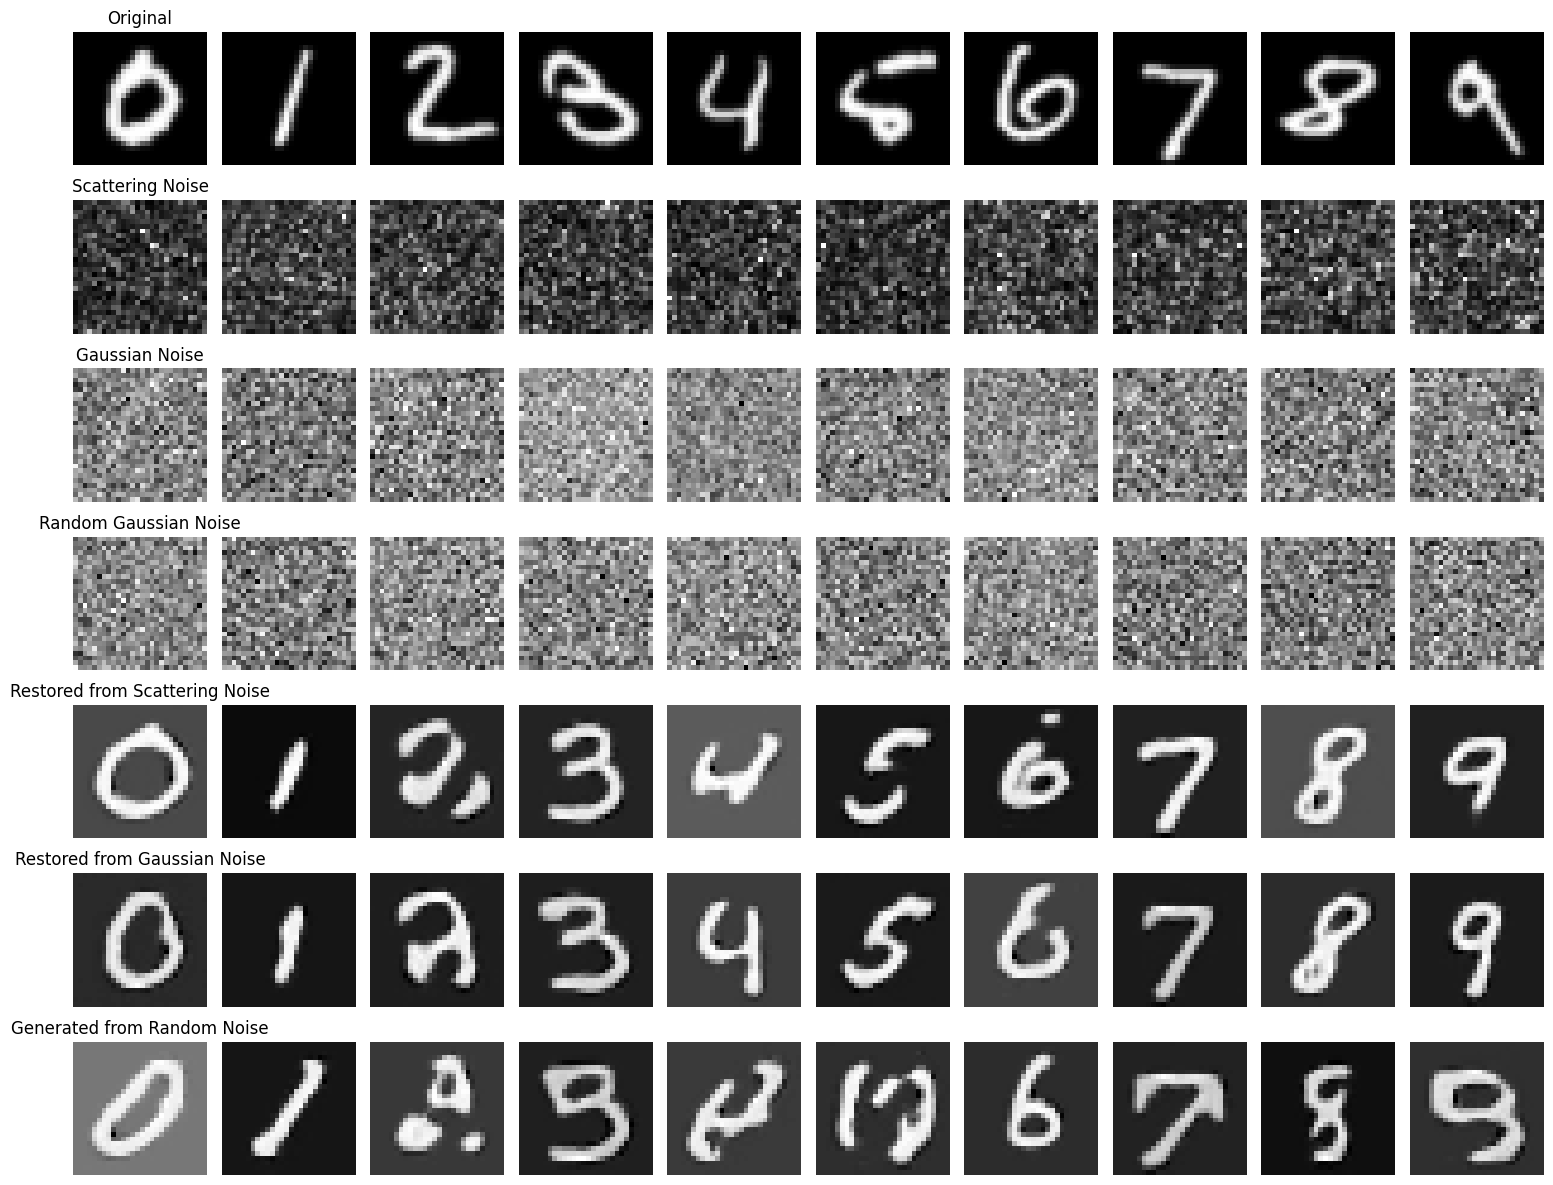

MS = 80, t = 8
스캐터링 노이즈 이미지 - PSNR: 11.13 dB, L2 거리: 7.8691
가우시안 노이즈 이미지 - PSNR: 6.76 dB, L2 거리: 12.8742
랜덤 가우시안 노이즈 - PSNR: -0.46 dB, L2 거리: 29.5404
스캐터링 노이즈 복원 이미지 SSIM: 0.3784
가우시안 노이즈 복원 이미지 SSIM: 0.4027
랜덤 노이즈 복원 이미지 SSIM: 0.2848



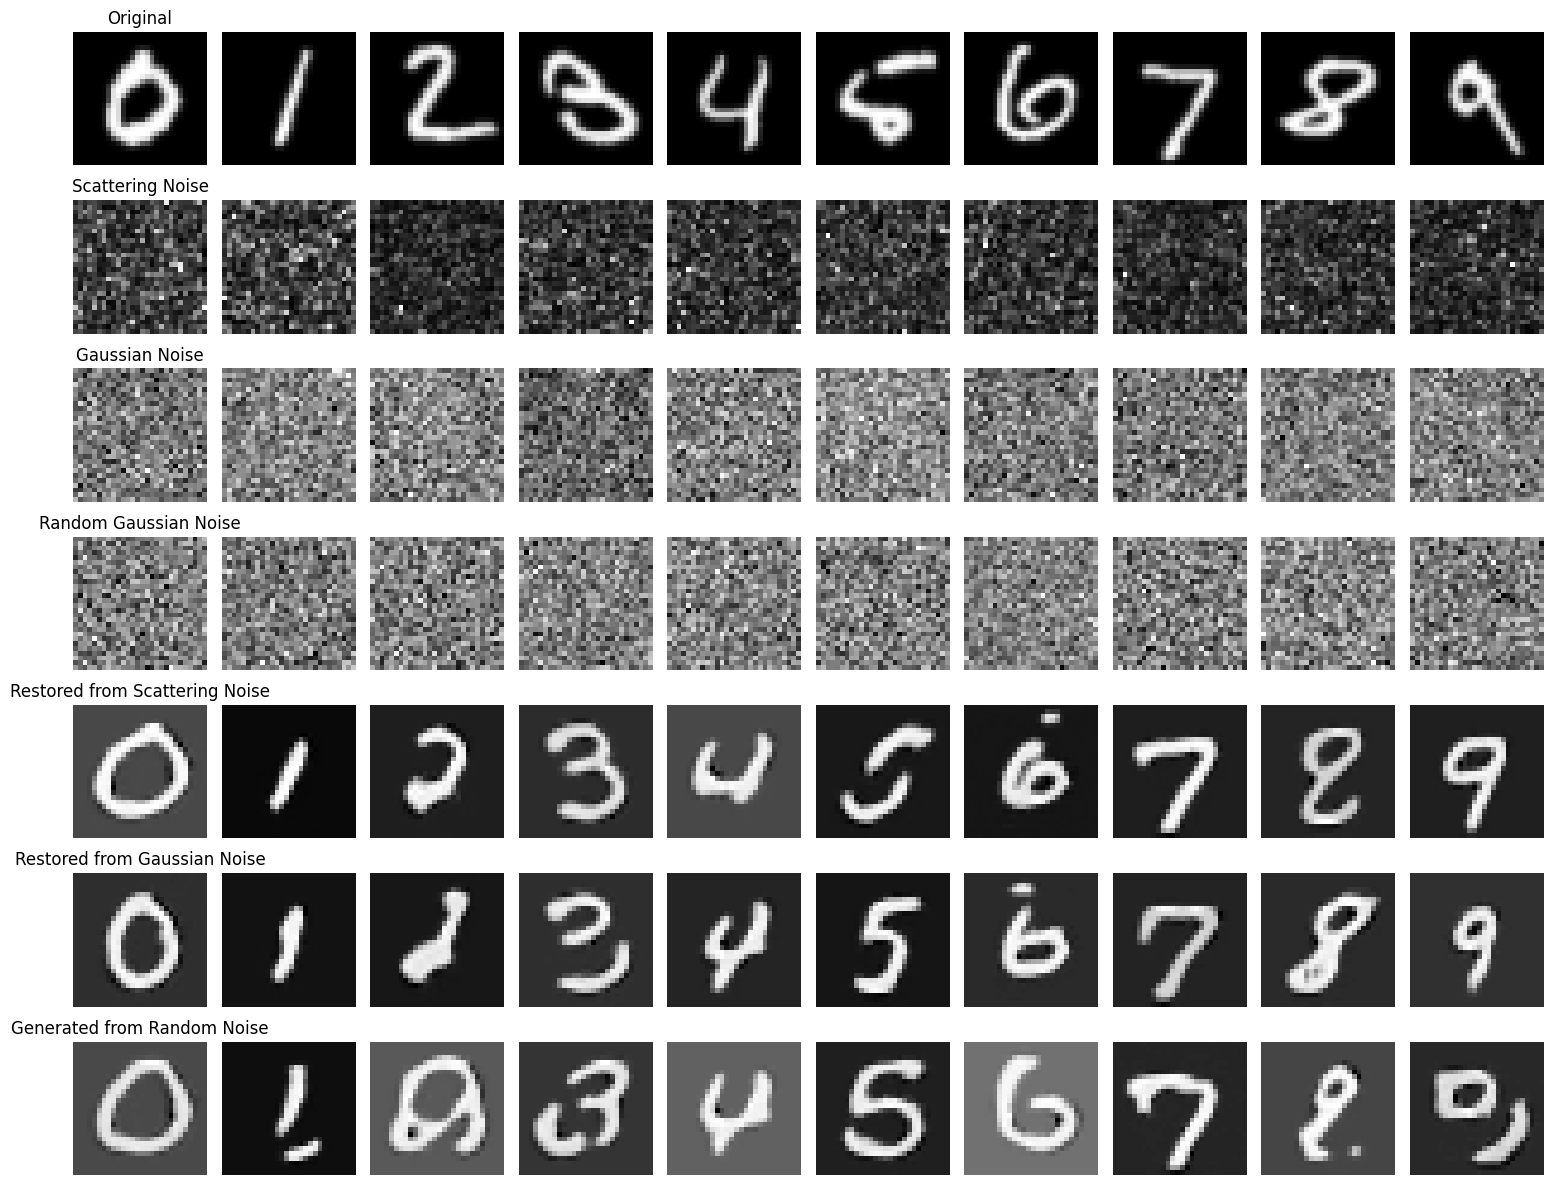

MS = 90, t = 9
스캐터링 노이즈 이미지 - PSNR: 11.10 dB, L2 거리: 7.8911
가우시안 노이즈 이미지 - PSNR: 6.57 dB, L2 거리: 13.1872
랜덤 가우시안 노이즈 - PSNR: -0.34 dB, L2 거리: 29.1236
스캐터링 노이즈 복원 이미지 SSIM: 0.3261
가우시안 노이즈 복원 이미지 SSIM: 0.3815
랜덤 노이즈 복원 이미지 SSIM: 0.2938



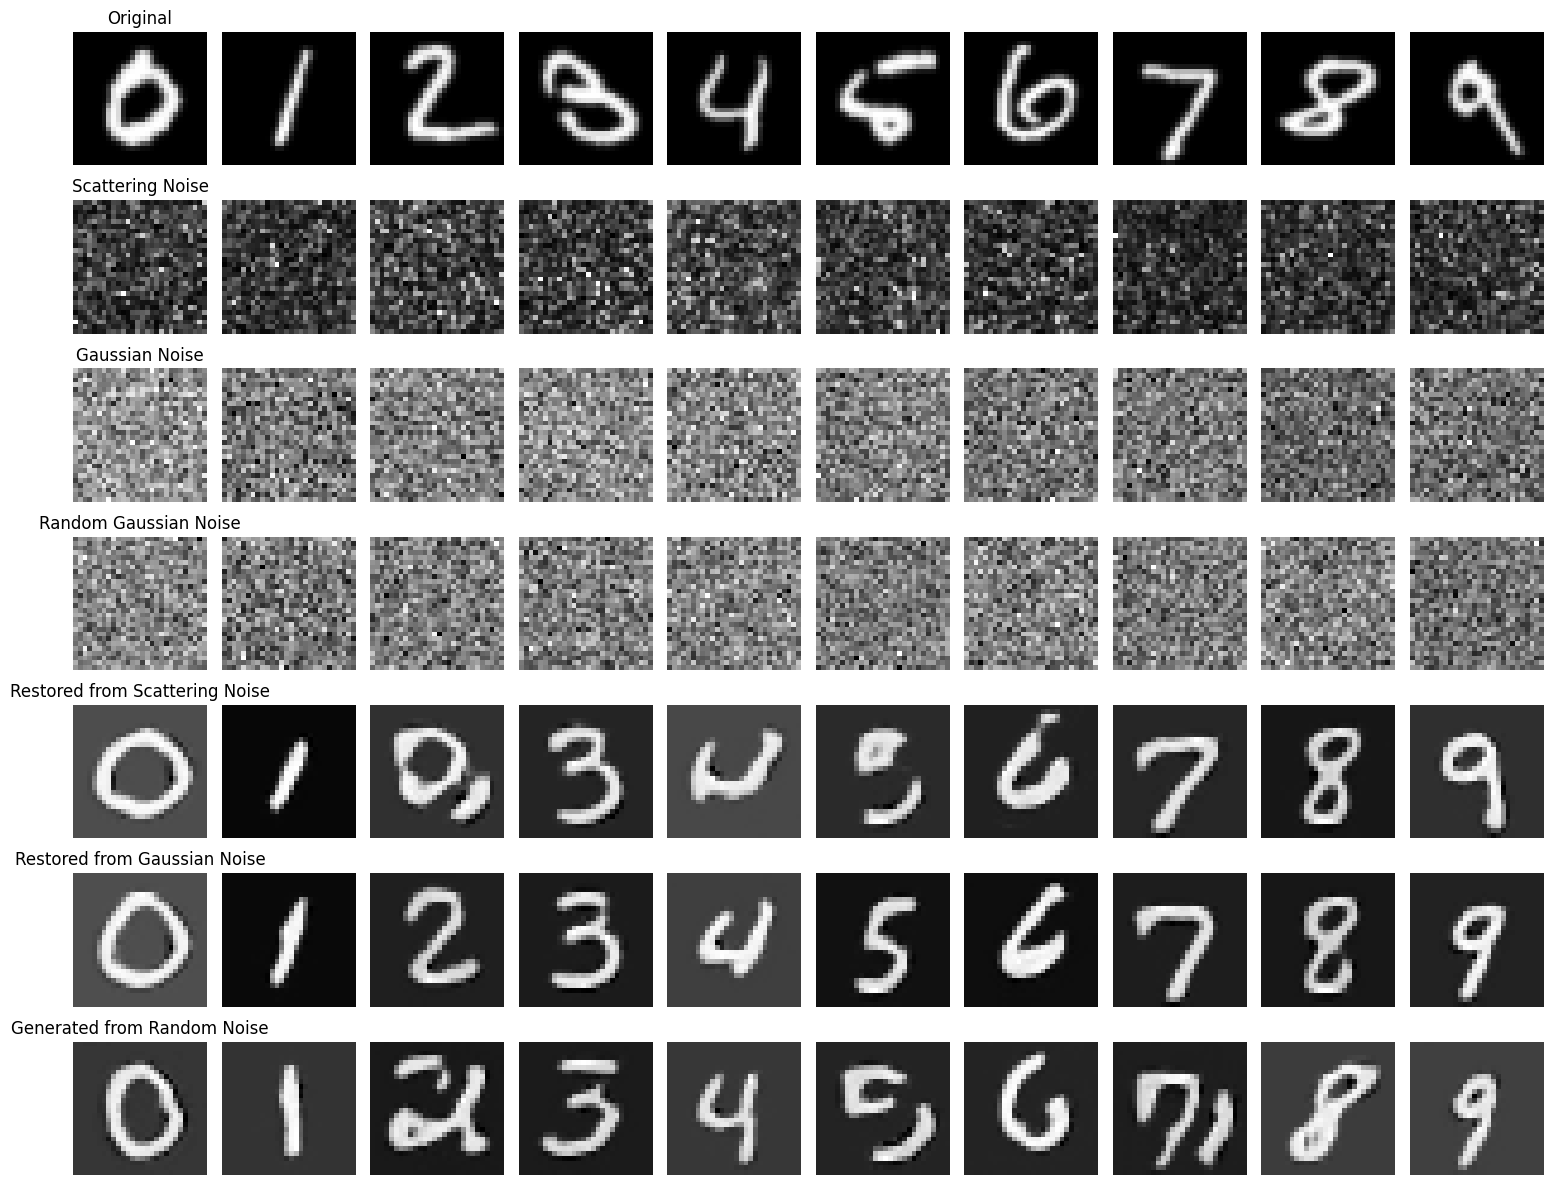

In [194]:
import numpy as np
import matplotlib.pyplot as plt
import torch
import torch.nn.functional as F
from torchvision import datasets, transforms
import cv2
from math import factorial
from skimage.metrics import peak_signal_noise_ratio as psnr
from skimage.metrics import structural_similarity as ssim

# 필요한 함수들 정의 (zernfun, gen_aberration 등)

def zernfun(n, m, r, theta, nflag=None):
    """
    Zernike functions of order N and frequency M on the unit circle.
    """
    # Input validation
    if not (np.ndim(n) == 1 and np.ndim(m) == 1):
        raise ValueError('N and M must be vectors.')

    if len(n) != len(m):
        raise ValueError('N and M must be the same length.')

    n = np.array(n).flatten()
    m = np.array(m).flatten()

    if np.any((n - m) % 2 != 0):
        raise ValueError('All N and M must differ by multiples of 2 (including 0).')

    if np.any(m > n):
        raise ValueError('Each M must be less than or equal to its corresponding N.')

    if np.any((r > 1) | (r < 0)):
        raise ValueError('All R must be between 0 and 1.')

    if not (np.ndim(r) == 1 and np.ndim(theta) == 1):
        raise ValueError('R and THETA must be vectors.')

    r = np.array(r).flatten()
    theta = np.array(theta).flatten()
    length_r = len(r)
    if length_r != len(theta):
        raise ValueError('The number of R- and THETA-values must be equal.')

    # Check normalization
    if nflag is not None and isinstance(nflag, str):
        isnorm = nflag.lower() == 'norm'
        if not isnorm and nflag != '':
            raise ValueError('Unrecognized normalization flag.')
    else:
        isnorm = False

    # Compute the Zernike polynomials
    m_abs = np.abs(m)
    rpowers = []
    for j in range(len(n)):
        rpowers.extend(range(int(m_abs[j]), int(n[j]) + 1, 2))
    rpowers = np.unique(rpowers)

    # Pre-compute the values of r raised to the required powers
    rpowern = np.zeros((length_r, len(rpowers)))
    for idx, p in enumerate(rpowers):
        rpowern[:, idx] = r ** p

    # Compute the values of the polynomials
    z = np.zeros((length_r, len(n)))
    for j in range(len(n)):
        n_j = int(n[j])
        m_abs_j = int(m_abs[j])
        s_max = (n_j - m_abs_j) // 2
        s = np.arange(0, s_max + 1)
        pows = np.arange(n_j, m_abs_j - 1, -2)
        for k in range(len(s)):
            s_k = int(s[k])
            pow_k = int(pows[k])
            numerator = (-1) ** s_k * factorial(n_j - s_k)
            denominator = (factorial(s_k) *
                           factorial((n_j + m_abs_j) // 2 - s_k) *
                           factorial((n_j - m_abs_j) // 2 - s_k))
            p = numerator / denominator
            idx_rpow = np.where(rpowers == pow_k)[0][0]
            z[:, j] += p * rpowern[:, idx_rpow]

        if isnorm:
            z[:, j] *= np.sqrt((1 + (m[j] != 0)) * (n[j] + 1) / np.pi)

    # Compute the Zernike functions
    idx_pos = m > 0
    idx_neg = m < 0

    if np.any(idx_pos):
        z[:, idx_pos] *= np.cos(theta[:, np.newaxis] * m_abs[idx_pos])
    if np.any(idx_neg):
        z[:, idx_neg] *= np.sin(theta[:, np.newaxis] * m_abs[idx_neg])

    return z

def gen_aberration(NA_mask, N_NA, max_value, Max_N):
    """
    Generate aberration phase map and coefficients
    """
    k_index = np.nonzero(NA_mask)
    N_img = NA_mask.shape[0]

    kx, ky = np.meshgrid(np.arange(1, N_img + 1), np.arange(1, N_img + 1))
    kc = np.mean(kx)
    kx = kx.astype(float) - kc
    ky = ky.astype(float) - kc
    kx = kx / float(N_NA)
    ky = ky / float(N_NA)
    kx = kx[k_index]
    ky = ky[k_index]

    N_z = []
    M_z = []
    for n in range(0, Max_N + 1):
        N_z.extend([n] * (n + 1))
        M_z.extend(range(-n, n + 1, 2))

    N_z = np.array(N_z)
    M_z = np.array(M_z)
    theta, rho = np.arctan2(ky, kx), np.hypot(kx, ky)
    z = zernfun(N_z, M_z, rho, theta)
    j_max = z.shape[1]

    z_norm = np.sum(z * z, axis=0)
    for j in range(j_max):
        if M_z[j] == 0:
            epsilon = 2
        else:
            epsilon = 1
        z_norm[j] = z_norm[j] * (2 * N_z[j] + 2) / (epsilon * np.pi)
    z_norm = np.sqrt(z_norm)

    linear_coeff = -max_value * (N_z - Max_N - 1).astype(float) / float(Max_N)
    z_coefficients = linear_coeff * (np.random.rand(j_max) - 0.5)

    z_coefficients[0] = 0  # DC offset

    tmp_map = np.sum(z * (z_coefficients / z_norm), axis=1)
    phase_map = np.zeros((N_img, N_img))
    phase_map[k_index] = tmp_map
    phase_map = (phase_map + np.pi) % (2 * np.pi) - np.pi

    return phase_map, z_coefficients

# MNIST 데이터셋 로드
mnist_testset = datasets.MNIST(root='./data', train=False, download=True,
                               transform=transforms.Compose([transforms.ToTensor()]))

# 각 숫자(0~9)에 대한 첫 번째 이미지를 가져옵니다.
original_images = [None for _ in range(10)]

for img, label in mnist_testset:
    if original_images[label] is None:
        img_np = img.squeeze().numpy()
        original_images[label] = img_np
    if all(image is not None for image in original_images):
        break

# 이미지를 80x80 크기로 리사이즈합니다.
tobj_list = [cv2.resize(img, (80, 80), interpolation=cv2.INTER_LINEAR) for img in original_images]

# 원본 이미지를 텐서로 변환
original_tensors = [torch.tensor(img_np, dtype=torch.float32).unsqueeze(0) for img_np in tobj_list]

# 모델 로드 및 설정
from models.diffusion import MNISTDiffusion

device = "cuda" if torch.cuda.is_available() else "cpu"

model = MNISTDiffusion()
model.load_state_dict(torch.load("mnist_diffusion.dth", map_location=device))
model.to(device)
model.eval()

# 이미지 리사이즈 함수 정의 (스캐터링 노이즈 이미지에만 적용)
def resize_images(image_list, size=(28, 28)):
    resized_images = []
    for img_np in image_list:
        img_resized = cv2.resize(img_np, size, interpolation=cv2.INTER_AREA)
        resized_images.append(torch.tensor(img_resized, dtype=torch.float32).unsqueeze(0))
    return resized_images

# 레이블 생성
class_label = torch.tensor([n for n in range(10)], dtype=torch.long).to(device)

# 이미지 생성 함수
def generate_images(model, noise, labels, start_step=0):
    model.eval()
    generated_images = noise.clone().to(device)
    with torch.no_grad():
        for t in reversed(range(start_step, model.num_steps)):
            generated_images = model(generated_images, labels, t)
    return generated_images

# PSNR, L2 거리 및 SSIM 계산 함수
def calculate_psnr_l2_ssim(original_images, noisy_images, restored_images):
    psnr_values = []
    l2_distances = []
    ssim_values = []

    for orig_img, noisy_img, restored_img in zip(original_images, noisy_images, restored_images):
        # numpy 배열로 변환
        orig_img_np = orig_img.squeeze().cpu().numpy()
        noisy_img_np = noisy_img.squeeze().cpu().numpy()
        restored_img_np = restored_img.squeeze().cpu().numpy()

        # PSNR 계산 (원본 이미지와 노이즈 이미지 간)
        psnr_value = psnr(orig_img_np, noisy_img_np, data_range=1.0)
        psnr_values.append(psnr_value)

        # L2 거리 계산 (원본 이미지와 노이즈 이미지 간)
        l2_distance = np.linalg.norm(orig_img_np - noisy_img_np)
        l2_distances.append(l2_distance)

        # SSIM 계산 (원본 이미지와 복원된 이미지 간)
        ssim_value = ssim(orig_img_np, restored_img_np, data_range=1.0)
        ssim_values.append(ssim_value)

    avg_psnr = np.mean(psnr_values)
    avg_l2_distance = np.mean(l2_distances)
    avg_ssim = np.mean(ssim_values)

    return avg_psnr, avg_l2_distance, avg_ssim

# MS와 t 값을 변경하면서 반복문 실행
MS_values = [0.1,1,5, 20,30,40,50,60,70,80,90]
t_values = [1,1,1,2,3,4,5,6,7,8,9]  # t_values의 길이를 MS_values와 맞추기 위해 1부터 11까지

# 결과를 저장할 리스트
results = []

for MS, t in zip(MS_values, t_values):
    # 스캐터링 노이즈가 추가된 이미지를 저장할 리스트
    noisy_images_fourier = []

    # 가우시안 노이즈가 추가된 이미지를 저장할 리스트
    noisy_images_gaussian = []

    # 완전한 랜덤 가우시안 노이즈를 저장할 리스트
    random_gaussian_noises = []
    generated_images_from_random_noise = []

    # 각 이미지에 대해 처리
    for idx, tobj in enumerate(tobj_list):
        # [00] Data options
        full_opt = 1  # 1600(1), 1264(0)
        basis = 'kx'  # kk, kx, rr

        target_opt = 'lm'

        abin_cpx = 'non'  # rand, non, exrand, (fix)
        about_cpx = 'non'
        about_fact = 10
        abin_fact = 10

        comp_opt = 'reim'  # angle, reim

        sc_opt = 1  # scattering off(0)/on(1)
        # MS 값 설정
        SM = 1 / MS  # single/multi intensity ratio

        # [0] Parameters setup

        NAsz = 20  # radius of pupil [pixel]
        matsz = 4 * NAsz  # [pixel]

        lamb = 0.8  # wavelength [um]
        dx = lamb / 0.4 / 2  # NA resolution
        xtick = dx * np.arange(1, matsz + 1) / 2
        xtick = xtick - np.mean(xtick)

        dk = 2 * 2 * np.pi / dx  # maximum k radius
        ktick = dk / matsz * np.arange(1, matsz + 1)
        ktick = ktick - np.mean(ktick)

        xx, yy = np.meshgrid(np.arange(1, matsz + 1), np.arange(1, matsz + 1))
        rr = (xx - np.mean(xx)) + 1j * (yy - np.mean(yy))

        cmask = np.sqrt((xx - np.mean(xx)) ** 2 + (yy - np.mean(yy)) ** 2) / NAsz
        cmask[cmask <= 1] = 1
        cmask[cmask > 1] = 0

        if full_opt == 1:
            nzind = np.arange(0, (2 * NAsz) ** 2)
        else:
            cmask_crop = cmask[NAsz:3 * NAsz, NAsz:3 * NAsz]
            nzind = np.nonzero(cmask_crop)

        if comp_opt == 'reim':
            data_mat = np.zeros((2 * NAsz, 2 * NAsz, len(nzind) * 2))
            truth_mat = np.zeros((2 * NAsz, 2 * NAsz, 4))

        # Prepare xin-kout (if basis is 'kx')
        if basis == 'kx':
            xinkout = np.zeros(((2 * NAsz) ** 2, (2 * NAsz) ** 2), dtype=complex)
            for ii in range((2 * NAsz) ** 2):
                xin = np.zeros((2 * NAsz, 2 * NAsz), dtype=complex)
                xin.flat[ii] = 1
                tmp = np.fft.ifftshift(np.fft.fft2(np.fft.fftshift(xin)))
                xinkout[:, ii] = tmp.flatten()

        # Continue with the rest of the computation
        xx, yy = np.meshgrid(np.arange(1, 4 * NAsz + 1), np.arange(1, 4 * NAsz + 1))
        re = 2
        cmask2 = np.sqrt((xx - np.mean(xx)) ** 2 + (yy - np.mean(yy)) ** 2) / (re * NAsz)
        cmask2[cmask2 <= 1] = 1
        cmask2[cmask2 > 1] = 0

        target = np.fft.fftshift(np.fft.fft2(tobj))

        cmask = cmask.astype(bool)

        ktarget = target * cmask  # r=40 mask
        ktarget = ktarget[NAsz:3 * NAsz, NAsz:3 * NAsz]

        xtarget = np.fft.ifft2(np.fft.ifftshift(target))

        # Generate kin-kout matrix
        kxtmp, kytmp = np.meshgrid(np.arange(-NAsz, NAsz), np.arange(-NAsz, NAsz))
        kx = kxtmp.flatten()
        ky = kytmp.flatten()
        n1 = (2 * NAsz) ** 2

        Smat = np.zeros((n1, n1), dtype=complex)

        for ii in range(n1):
            tmp = np.roll(np.roll(target, int(kx[ii]), axis=0), int(ky[ii]), axis=1) * cmask
            tmp = tmp[NAsz:3 * NAsz, NAsz:3 * NAsz]
            Smat[:, ii] = tmp.flatten()

        # Create input/output pupil function matrix
        sz = 2 * NAsz
        kx2, ky2 = np.meshgrid(np.arange(1, sz + 1), np.arange(1, sz + 1))
        kc = NAsz + 0.5  # sz / 2 + 0.5
        NA_mask = (kx2 - kc) ** 2 + (ky2 - kc) ** 2 < NAsz ** 2
        roi_NA = np.arange(kc - NAsz, kc + NAsz)
        k_index = np.nonzero(NA_mask)

        ipf = np.zeros((2 * NAsz, 2 * NAsz), dtype=complex)
        opf = np.zeros((2 * NAsz, 2 * NAsz), dtype=complex)

        # Aberration 설정
        if abin_cpx == 'rand':
            abin_fact = 10 + 50 * np.random.rand()  # degree of aberration (10~60)
            ab_phase_map, z_coeff = gen_aberration(NA_mask, NAsz, 50, int(abin_fact))
            ipf[k_index] = np.exp(1j * ab_phase_map[k_index])
        elif abin_cpx == 'non':
            ipf[NA_mask] = 1.0  # no aberration

        if about_cpx == 'rand':
            about_fact = 10 + 50 * np.random.rand()  # degree of aberration (10~60)
            ab_phase_map_opf, z_coeff_opf = gen_aberration(NA_mask, NAsz, 50, int(about_fact))
            opf[k_index] = np.exp(1j * ab_phase_map_opf[k_index])
        elif about_cpx == 'non':
            opf[NA_mask] = 1.0  # no aberration

        # Apply pupil functions
        ipf_flat = ipf.flatten()
        opf_flat = opf.flatten()

        Smat = (opf_flat[:, np.newaxis]) * Smat * (ipf_flat[np.newaxis, :])

        kxmat = Smat
        kxmat = kxmat[:, nzind]

        if basis == 'kx':
            kxmat = kxmat @ xinkout

        if basis == 'rr':
            kxmat = kxmat @ kxmat.T

        if sc_opt == 1:
            chan = kxmat.shape[0]
            Mmat = np.random.randn(chan, chan) + 1j * np.random.randn(chan, chan)

            IM = np.mean(np.sum(np.abs(Mmat) ** 2))
            IS = np.mean(np.sum(np.abs(kxmat) ** 2))

            mat = kxmat * np.sqrt(IM / IS * SM) + Mmat
            kxmat = mat[:, nzind]
        else:
            kxmat = kxmat[:, nzind]

        # 복소수 데이터 복원
        num_channels = kxmat.shape[1]

        complex_image = np.zeros((2 * NAsz, 2 * NAsz), dtype=complex)

        for i in range(num_channels):
            complex_image += kxmat[:, i].reshape(2 * NAsz, 2 * NAsz)

        # 역변환하여 이미지 복원
        reconstructed_image = np.fft.ifft2(complex_image)

        # 실수부를 취하고 정규화
        reconstructed_magnitude = np.abs(reconstructed_image)**2
        reconstructed_magnitude /= np.max(reconstructed_magnitude)

        # 스캐터링 노이즈가 추가된 이미지를 저장
        noisy_image_fourier = reconstructed_magnitude.astype(np.float32)
        noisy_images_fourier.append(noisy_image_fourier)

        # 가우시안 노이즈 추가 부분 수정: 모델의 Forward Diffusion Process 사용
        # 이미지를 28x28로 리사이즈하고 텐서로 변환
        img_resized = cv2.resize(tobj, (28, 28), interpolation=cv2.INTER_AREA)
        img_tensor = torch.tensor(img_resized, dtype=torch.float32).unsqueeze(0).unsqueeze(0).to(device)

        # 노이즈 단계 설정
        t_noise = t

        # Forward Diffusion Process를 통해 노이즈 추가
        noisy_image = img_tensor.clone()
        with torch.no_grad():
            for step in range(t_noise):
                noisy_image = model(noisy_image, backward=False)

        # 노이즈가 추가된 이미지를 저장
        noisy_images_gaussian.append(noisy_image.cpu().squeeze(0))

        # 완전한 랜덤 가우시안 노이즈 생성
        random_noise = torch.randn_like(img_tensor).cpu().squeeze(0)
        random_gaussian_noises.append(random_noise)

    # 스캐터링 노이즈 이미지를 리사이즈하고 텐서로 변환
    noisy_images_fourier_tensors = resize_images(noisy_images_fourier)

    # 원본 이미지를 리사이즈하고 텐서로 변환
    original_tensors_resized = resize_images([img.squeeze().numpy() for img in original_tensors])

    # 결과를 시각화하기 위해 리스트를 준비
    original = original_tensors_resized
    noisy_images_fourier = noisy_images_fourier_tensors

    # 가우시안 노이즈 이미지는 이미 텐서로 변환되어 있으므로 그대로 사용
    noisy_images_gaussian_tensors = noisy_images_gaussian

    # 완전한 랜덤 가우시안 노이즈로부터 이미지 생성
    random_gaussian_noise_tensor = torch.stack(random_gaussian_noises).to(device)
    result_random_noise = generate_images(model, random_gaussian_noise_tensor, class_label, start_step=1).cpu().detach()
    generated_images_from_random_noise = result_random_noise

    # 스캐터링 노이즈 이미지로부터 결과 생성
    noisy_images_fourier_tensor = torch.stack(noisy_images_fourier).to(device)
    result_fourier = generate_images(model, noisy_images_fourier_tensor, class_label, start_step = model.num_steps - t).cpu().detach()

    # 가우시안 노이즈 이미지로부터 결과 생성
    noisy_images_gaussian_tensor = torch.stack(noisy_images_gaussian_tensors).to(device)
    result_gaussian = generate_images(model, noisy_images_gaussian_tensor, class_label, start_step = model.num_steps - t).cpu().detach()

    # PSNR, L2 거리 및 SSIM 계산
    avg_psnr_fourier, avg_l2_fourier, avg_ssim_fourier = calculate_psnr_l2_ssim(original, noisy_images_fourier, result_fourier)
    avg_psnr_gaussian, avg_l2_gaussian, avg_ssim_gaussian = calculate_psnr_l2_ssim(original, noisy_images_gaussian_tensors, result_gaussian)
    avg_psnr_random, avg_l2_random, avg_ssim_random = calculate_psnr_l2_ssim(original, random_gaussian_noises, generated_images_from_random_noise)

    # 결과 출력
    print(f"MS = {MS}, t = {t}")
    print(f"스캐터링 노이즈 이미지 - PSNR: {avg_psnr_fourier:.2f} dB, L2 거리: {avg_l2_fourier:.4f}")
    print(f"가우시안 노이즈 이미지 - PSNR: {avg_psnr_gaussian:.2f} dB, L2 거리: {avg_l2_gaussian:.4f}")
    print(f"랜덤 가우시안 노이즈 - PSNR: {avg_psnr_random:.2f} dB, L2 거리: {avg_l2_random:.4f}")
    print(f"스캐터링 노이즈 복원 이미지 SSIM: {avg_ssim_fourier:.4f}")
    print(f"가우시안 노이즈 복원 이미지 SSIM: {avg_ssim_gaussian:.4f}")
    print(f"랜덤 노이즈 복원 이미지 SSIM: {avg_ssim_random:.4f}\n")

    # 결과를 저장
    results.append({
        'MS': MS,
        't': t,
        'PSNR_Fourier': avg_psnr_fourier,
        'L2_Fourier': avg_l2_fourier,
        'SSIM_Restored_Fourier': avg_ssim_fourier,
        'PSNR_Gaussian': avg_psnr_gaussian,
        'L2_Gaussian': avg_l2_gaussian,
        'SSIM_Restored_Gaussian': avg_ssim_gaussian,
        'PSNR_Random': avg_psnr_random,
        'L2_Random': avg_l2_random,
        'SSIM_Restored_Random': avg_ssim_random
    })

    # 결과 시각화
    fig, ax = plt.subplots(nrows=7, ncols=10, figsize=(15, 12))

    # 원본 이미지 시각화
    for i, image in enumerate(original):
        ax[0, i].imshow(image.squeeze(), cmap="gray")
        ax[0, i].axis("off")
        if i == 0:
            ax[0, i].set_title("Original")

    # 스캐터링 노이즈 이미지 시각화
    for i, image in enumerate(noisy_images_fourier):
        ax[1, i].imshow(image.squeeze(), cmap="gray")
        ax[1, i].axis("off")
        if i == 0:
            ax[1, i].set_title("Scattering Noise")

    # 가우시안 노이즈 이미지 시각화
    for i, image in enumerate(noisy_images_gaussian_tensors):
        ax[2, i].imshow(image.squeeze(), cmap="gray")
        ax[2, i].axis("off")
        if i == 0:
            ax[2, i].set_title("Gaussian Noise")

    # 랜덤 가우시안 노이즈 시각화
    for i, image in enumerate(random_gaussian_noises):
        ax[3, i].imshow(image.squeeze(), cmap="gray")
        ax[3, i].axis("off")
        if i == 0:
            ax[3, i].set_title("Random Gaussian Noise")

    # 스캐터링 노이즈 이미지로부터 생성된 결과 시각화
    for i, image in enumerate(result_fourier):
        ax[4, i].imshow(image.squeeze(), cmap="gray")
        ax[4, i].axis("off")
        if i == 0:
            ax[4, i].set_title("Restored from Scattering Noise")
    # 가우시안 노이즈 이미지로부터 생성된 결과 시각화
    for i, image in enumerate(result_gaussian):
        ax[5, i].imshow(image.squeeze(), cmap="gray")
        ax[5, i].axis("off")
        if i == 0:
            ax[5, i].set_title("Restored from Gaussian Noise")
    # 랜덤 가우시안 노이즈로부터 생성된 결과 시각화
    for i, image in enumerate(generated_images_from_random_noise):
        ax[6, i].imshow(image.squeeze(), cmap="gray")
        ax[6, i].axis("off")
        if i == 0:
            ax[6, i].set_title("Generated from Random Noise")

    plt.tight_layout()
    plt.show()


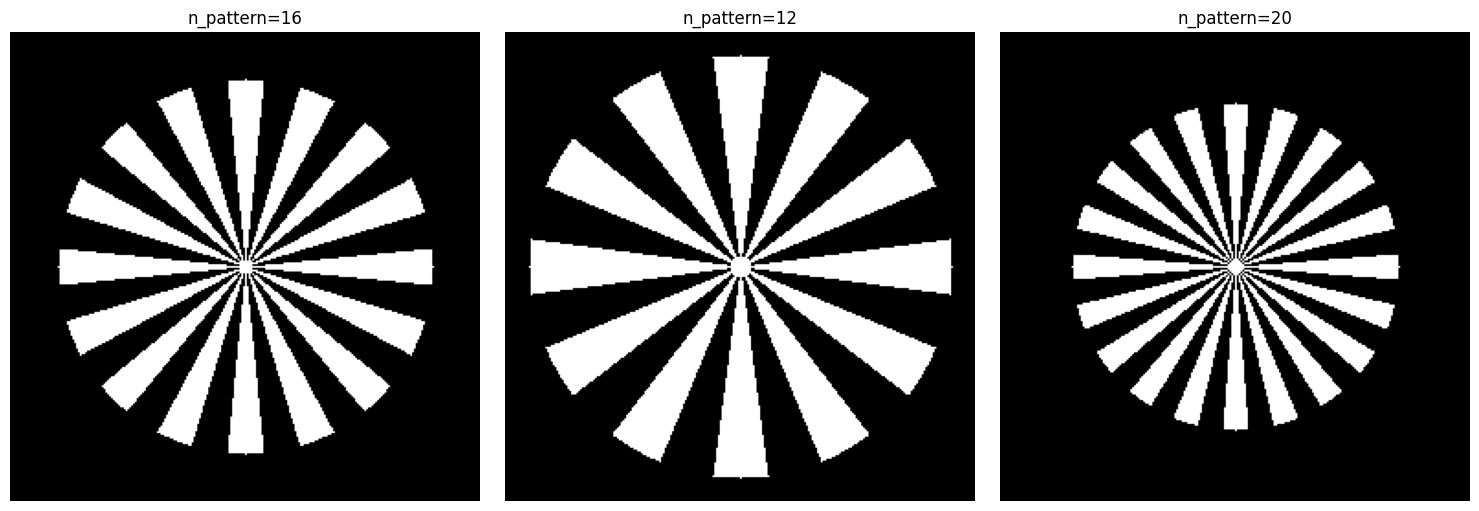

In [18]:
import numpy as np
import matplotlib.pyplot as plt

def siemens(sz, ratio, n_pattern, center_fill=1/30, start_angle=0):
    dtheta = 360 / (2 * n_pattern)
    start_angle = 3 * dtheta / 2

    center = sz // 2
    R_o = ratio * sz // 2
    R_i = center_fill * sz // 2
    theta = np.zeros((sz, sz))

    for x in range(sz):
        for y in range(sz):
            if (y - center) >= 0:
                if (x - center) >= 0:
                    theta[y, x] = np.degrees(np.arctan2((y - center), (x - center)))
                else:
                    theta[y, x] = 180 + np.degrees(np.arctan2((y - center), (x - center)))
            else:
                if (x - center) >= 0:
                    theta[y, x] = 360 + np.degrees(np.arctan2((y - center), (x - center)))
                else:
                    theta[y, x] = 180 + np.degrees(np.arctan2((y - center), (x - center)))

    theta[int(center), int(center)] = 0
    theta = theta + start_angle
    target = np.mod(np.fix(theta / dtheta), 2)

    x, y = np.meshgrid(np.arange(0, sz), np.arange(0, sz))
    target[((x - center) ** 2 + (y - center) ** 2 > R_o ** 2)] = 0
    target[((x - center) ** 2 + (y - center) ** 2 < R_i ** 2)] = 1

    return target

# Generate and visualize sample images
def visualize_siemens_samples():
    samples = [
        {"sz": 256, "ratio": 0.8, "n_pattern": 16, "center_fill": 1/30},
        {"sz": 256, "ratio": 0.9, "n_pattern": 12, "center_fill": 1/20},
        {"sz": 256, "ratio": 0.7, "n_pattern": 20, "center_fill": 1/40},
    ]

    fig, axs = plt.subplots(1, len(samples), figsize=(15, 5))

    for i, params in enumerate(samples):
        img = siemens(**params)
        axs[i].imshow(img, cmap="gray")
        axs[i].set_title(f"n_pattern={params['n_pattern']}")
        axs[i].axis("off")

    plt.tight_layout()
    plt.show()

visualize_siemens_samples()
